Define Cleaning Function & Room–Age Mapping
In this cell, we import pandas, datetime utilities, and re, then define our core mappings: which room corresponds to which age group, and the staff-to-child ratios for infants, toddlers, preschoolers, pre-K, and multi-age rooms. We then implement clean_csi_file(filepath, start_date), which (a) reads the raw Excel attendance log (skipping header rows), (b) filters to active students only, (c) expands each check-in/out interval into discrete 30-minute bins, (d) counts how many children are present in each bin, (e) assigns an age group to every record, and (f) computes the minimum required staff per block—applying both the age-ratio rule and a floor of two staff per room. Finally, we call this function for the 2022 ECEC file, save the cleaned output, and confirm the first few rows look correct.



In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import re

# Base Room → Age Group mapping
room_age_group = {
    "Good Night Moon": "Infant", "House of Pooh": "Infant", "Panda Bear": "Toddler",
    "Rabbits": "Toddler", "Monkeys": "Toddler", "Caterpillars": "Multi-Age",
    "Llama Llama": "Multi-Age", "Rainbow Fish": "Preschool", "Wild Things": "Preschool",
    "Dinosaurs": "Pre-K", "Pennie Infants": "Infant", "Henry Infants": "Infant",
    "Pennie Toddlers": "Toddler", "Henry Toddlers": "Toddler",
    "Pennie Multi-Age": "Multi-Age", "Henry Multi-Age": "Multi-Age",
    "Grampy Tom Multi-Age": "Multi-Age", "Pennie Preschool 1": "Preschool",
    "Pennie Preschool 2": "Preschool", "Pre-K1": "Pre-K", "Pre-K2": "Pre-K",
    "Grampy Tom Preschool": "Preschool", "Grampy Tom Toddlers": "Toddler",
    "Dinosaur Stomp": "Pre-K", "Pandas": "Toddler", "Llamas Llamas": "Multi-Age",
    "Hungry Caterpillars": "Multi-Age", "Goodnight Moon": "Infant", "House Pooh": "Infant"
}

def clean_csi_file(filepath, start_date):
    df_raw = pd.read_excel(filepath, skiprows=6)

    # Extract static student info
    df_static = df_raw[['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 5', 'Unnamed: 4']]
    df_static.columns = ['First Name', 'Last Name', 'Record ID', 'Room', 'Student Status']
    active_ids = df_static[df_static['Student Status'].str.strip().str.lower() == 'active']['Record ID'].unique()

    # Extract check-in/out records
    records = []
    day_idx = 0
    start_col = 7
    while start_col + 1 < len(df_raw.columns):
        date = start_date + timedelta(days=day_idx)
        checkin_col = df_raw.columns[start_col]
        checkout_col = df_raw.columns[start_col + 1]
        for idx in range(1, len(df_raw)):
            row = df_raw.iloc[idx]
            if row['Unnamed: 2'] not in active_ids:
                continue
            checkin = row[checkin_col]
            checkout = row[checkout_col]
            if pd.notnull(checkin) and pd.notnull(checkout):
                records.append({
                    'Record ID': row['Unnamed: 2'],
                    'Room': row['Unnamed: 5'],
                    'Date': date,
                    'Check In Raw': str(checkin),
                    'Check Out Raw': str(checkout)
                })
        start_col += 2
        day_idx += 1

    df = pd.DataFrame(records)

    # Extract clean times
    def extract_time(text):
        match = re.match(r"([\d:]+ [APMapm]+)", text)
        return match.group(1) if match else pd.NA

    df['Check In Time'] = df['Check In Raw'].apply(extract_time)
    df['Check Out Time'] = df['Check Out Raw'].apply(extract_time)

    # Suppress datetime parsing warnings
    df['Check In Datetime'] = pd.to_datetime(
        df['Date'].astype(str) + ' ' + df['Check In Time'],
        format="%Y-%m-%d %I:%M %p", errors='coerce'
    )
    df['Check Out Datetime'] = pd.to_datetime(
        df['Date'].astype(str) + ' ' + df['Check Out Time'],
        format="%Y-%m-%d %I:%M %p", errors='coerce'
    )

    # Generate 30-minute intervals
    intervals = []
    for _, row in df.iterrows():
        start = row['Check In Datetime']
        end = row['Check Out Datetime']
        original_room = str(row['Room']).strip().title()
        age_group = room_age_group.get(original_room, "Unknown")

        if pd.isna(start) or pd.isna(end) or start >= end:
            continue

        # Round down to nearest 30-min block
        current = start.replace(minute=(start.minute // 30) * 30, second=0)

        while current < end:
            intervals.append({
                'Date': current.date(),
                'Room': original_room,
                'Age Group': age_group,
                'Time': current.time().strftime('%H:%M:%S')
            })
            current += timedelta(minutes=30)

    df_interval = pd.DataFrame(intervals)

    # Report any unmapped rooms
    unknown_rooms = df_interval[df_interval['Age Group'] == 'Unknown']['Room'].unique()
    if len(unknown_rooms) > 0:
        print("❗ Unmapped (Unknown) Room Names Detected:")
        print(unknown_rooms)

    # Group and count
    df_result = df_interval.groupby(['Date','Room','Age Group','Time']).size().reset_index(name='Num_Children')

    # Staff ratio mapping
    staff_ratios = {
        'Infant': 4, 'Multi-Age': 4, 'Toddler': 6,
        'Preschool': 10, 'Pre-K': 12
    }

    # Calculate staff needed
    df_result['Ratio'] = df_result['Age Group'].map(staff_ratios)
    df_result['Staff_Needed'] = df_result.apply(
        lambda row: max(2, -(-row['Num_Children'] // row['Ratio'])) if pd.notnull(row['Ratio']) else 2,
        axis=1
    )

    return df_result
file_path = "/content/ECEC 2022 Student Sign In and Out.xlsx"
start_date = datetime(2022, 1, 1)

df_result = clean_csi_file(file_path, start_date)
df_result.to_csv("ECEC_2022_Cleaned_with_Staff.csv", index=False)
print(df_result.head())



         Date    Room Age Group      Time  Num_Children  Ratio  Staff_Needed
0  2022-01-03  Pre-K1     Pre-K  07:30:00             3     12             2
1  2022-01-03  Pre-K1     Pre-K  08:00:00             3     12             2
2  2022-01-03  Pre-K1     Pre-K  08:30:00             3     12             2
3  2022-01-03  Pre-K1     Pre-K  09:00:00             4     12             2
4  2022-01-03  Pre-K1     Pre-K  09:30:00             4     12             2


Clean ECEC Data for 2023, 2024, and Early 2025
Here we repeat the clean_csi_file process for each subsequent ECEC file: the full years 2023 and 2024, plus the partial 2025 log. For each workbook, we set the appropriate file_path and start_date, invoke our cleaning function, export a "ECEC_<year>_Cleaned_with_Staff.csv", and print a preview. This ensures all ECEC years share the same cleaning logic and output schema.



In [ ]:
file_path = "/content/ECEC 2023 Student Sign In and Out.xlsx"
start_date = datetime(2023, 1, 1)

df_result = clean_csi_file(file_path, start_date)
df_result.to_csv("ECEC_2023_Cleaned_with_Staff.csv", index=False)
print(df_result.head())

         Date                  Room  Age Group      Time  Num_Children  Ratio  \
0  2023-01-03  Grampy Tom Preschool  Preschool  07:30:00             2     10   
1  2023-01-03  Grampy Tom Preschool  Preschool  08:00:00             6     10   
2  2023-01-03  Grampy Tom Preschool  Preschool  08:30:00             9     10   
3  2023-01-03  Grampy Tom Preschool  Preschool  09:00:00             9     10   
4  2023-01-03  Grampy Tom Preschool  Preschool  09:30:00             9     10   

   Staff_Needed  
0             2  
1             2  
2             2  
3             2  
4             2  


In [ ]:
file_path = "/content/ECEC 2024 Student Sign In and Out.xlsx"
start_date = datetime(2024, 1, 1)

df_result = clean_csi_file(file_path, start_date)
df_result.to_csv("ECEC_2024_Cleaned_with_Staff.csv", index=False)
print(df_result.head())

         Date                  Room  Age Group      Time  Num_Children  Ratio  \
0  2024-01-02  Grampy Tom Multi-Age  Multi-Age  07:30:00             1      4   
1  2024-01-02  Grampy Tom Multi-Age  Multi-Age  08:00:00             1      4   
2  2024-01-02  Grampy Tom Multi-Age  Multi-Age  08:30:00             1      4   
3  2024-01-02  Grampy Tom Multi-Age  Multi-Age  09:00:00             1      4   
4  2024-01-02  Grampy Tom Multi-Age  Multi-Age  09:30:00             1      4   

   Staff_Needed  
0             2  
1             2  
2             2  
3             2  
4             2  


In [ ]:
file_path = "/content/ECEC 2025 01012025-02282025 Student Sign In and Out.xlsx"
start_date = datetime(2025, 1, 1)

df_result = clean_csi_file(file_path, start_date)
df_result.to_csv("ECEC_2025_Cleaned_with_Staff.csv", index=False)
print(df_result.head())

         Date                  Room  Age Group      Time  Num_Children  Ratio  \
0  2025-01-02  Grampy Tom Preschool  Preschool  07:30:00             1     10   
1  2025-01-02  Grampy Tom Preschool  Preschool  08:00:00             5     10   
2  2025-01-02  Grampy Tom Preschool  Preschool  08:30:00             9     10   
3  2025-01-02  Grampy Tom Preschool  Preschool  09:00:00             9     10   
4  2025-01-02  Grampy Tom Preschool  Preschool  09:30:00             9     10   

   Staff_Needed  
0             2  
1             2  
2             2  
3             2  
4             2  


Clean Spellman CDC Data (2022–2025)
Analogous to the ECEC steps, these four cells call clean_csi_file on Spellman CDC’s 2022–2025 check-in/out workbooks. Each cleaned DataFrame is written to "Spellman_<year>_Cleaned_with_Staff.csv". By treating both sites identically, we guarantee consistent staff-need calculations across centers.

In [ ]:
file_path = "/content/Spellman CDC 2022 Student Sign in and out.xlsx"
start_date = datetime(2022, 1, 1)

df_result = clean_csi_file(file_path, start_date)
df_result.to_csv("Spellman_2022_Cleaned_with_Staff.csv", index=False)
print(df_result.head())

         Date            Room Age Group      Time  Num_Children  Ratio  \
0  2022-01-03  Dinosaur Stomp     Pre-K  07:30:00             2     12   
1  2022-01-03  Dinosaur Stomp     Pre-K  08:00:00             4     12   
2  2022-01-03  Dinosaur Stomp     Pre-K  08:30:00             7     12   
3  2022-01-03  Dinosaur Stomp     Pre-K  09:00:00             8     12   
4  2022-01-03  Dinosaur Stomp     Pre-K  09:30:00             8     12   

   Staff_Needed  
0             2  
1             2  
2             2  
3             2  
4             2  


In [ ]:
file_path = "/content/Spellman CDC 2023 Student Sign in and out.xlsx"
start_date = datetime(2023, 1, 1)

df_result = clean_csi_file(file_path, start_date)
df_result.to_csv("Spellman_2023_Cleaned_with_Staff.csv", index=False)
print(df_result.head())

         Date            Room Age Group      Time  Num_Children  Ratio  \
0  2023-01-03  Dinosaur Stomp     Pre-K  07:00:00             1     12   
1  2023-01-03  Dinosaur Stomp     Pre-K  07:30:00             3     12   
2  2023-01-03  Dinosaur Stomp     Pre-K  08:00:00             6     12   
3  2023-01-03  Dinosaur Stomp     Pre-K  08:30:00             9     12   
4  2023-01-03  Dinosaur Stomp     Pre-K  09:00:00            11     12   

   Staff_Needed  
0             2  
1             2  
2             2  
3             2  
4             2  


In [ ]:
file_path = "/content/Spellman CDC 2024 Student Sign in and out.xlsx"
start_date = datetime(2024, 1, 1)

df_result = clean_csi_file(file_path, start_date)
df_result.to_csv("Spellman_2024_Cleaned_with_Staff.csv", index=False)
print(df_result.head())

         Date            Room Age Group      Time  Num_Children  Ratio  \
0  2024-01-02  Dinosaur Stomp     Pre-K  07:30:00             2     12   
1  2024-01-02  Dinosaur Stomp     Pre-K  08:00:00             6     12   
2  2024-01-02  Dinosaur Stomp     Pre-K  08:30:00            11     12   
3  2024-01-02  Dinosaur Stomp     Pre-K  09:00:00            13     12   
4  2024-01-02  Dinosaur Stomp     Pre-K  09:30:00            13     12   

   Staff_Needed  
0             2  
1             2  
2             2  
3             2  
4             2  


In [ ]:
file_path = "/content/Spellman CDC 2025 01012025-02282025 Student Sign in and out.xlsx"
start_date = datetime(2025, 1, 1)

df_result = clean_csi_file(file_path, start_date)
df_result.to_csv("Spellman_2025_Cleaned_with_Staff.csv", index=False)
print(df_result.head())

         Date            Room Age Group      Time  Num_Children  Ratio  \
0  2025-01-02  Dinosaur Stomp     Pre-K  07:30:00             3     12   
1  2025-01-02  Dinosaur Stomp     Pre-K  08:00:00            10     12   
2  2025-01-02  Dinosaur Stomp     Pre-K  08:30:00            14     12   
3  2025-01-02  Dinosaur Stomp     Pre-K  09:00:00            15     12   
4  2025-01-02  Dinosaur Stomp     Pre-K  09:30:00            15     12   

   Staff_Needed  
0             2  
1             2  
2             2  
3             2  
4             2  


Merge All Cleaned ECEC Files
Now that each year’s ECEC data is cleaned and saved, we list those four CSVs and load them into a list of DataFrames. We concatenate them into one master merged_df and write "ECEC_2022_to_2025_Merged.csv". A quick head() confirms the merge succeeded—giving us a continuous, multi-year table of 30-minute staff needs for ECEC.



In [ ]:
import pandas as pd

# List of cleaned yearly CSV file paths
files = [
    "ECEC_2022_Cleaned_with_Staff.csv",
    "ECEC_2023_Cleaned_with_Staff.csv",
    "ECEC_2024_Cleaned_with_Staff.csv",
    "ECEC_2025_Cleaned_with_Staff.csv"
]

# Load each CSV file into a DataFrame and store them in a list
dataframes = [pd.read_csv(file) for file in files]

# Concatenate all the DataFrames into one
merged_df = pd.concat(dataframes, ignore_index=True)

# Save the merged dataset to a new CSV
merged_df.to_csv("ECEC_2022_to_2025_Merged.csv", index=False)

# Optionally display the first few rows
print(merged_df.head())


         Date    Room Age Group      Time  Num_Children  Ratio  Staff_Needed
0  2022-01-03  Pre-K1     Pre-K  07:30:00             3     12             2
1  2022-01-03  Pre-K1     Pre-K  08:00:00             3     12             2
2  2022-01-03  Pre-K1     Pre-K  08:30:00             3     12             2
3  2022-01-03  Pre-K1     Pre-K  09:00:00             4     12             2
4  2022-01-03  Pre-K1     Pre-K  09:30:00             4     12             2


Merge All Cleaned Spellman CDC Files
We repeat the merge process for Spellman: read each "Spellman_<year>_Cleaned_with_Staff.csv", concatenate into merged_spellman, and output "Spellman_2022_to_2025_Merged.csv". At this point, both centers have their own consolidated, cleaned staff-need datasets ready for joint analysis.

In [ ]:
import pandas as pd

# List of cleaned Spellman files
spellman_files = [
    "Spellman_2022_Cleaned_with_Staff.csv",
    "Spellman_2023_Cleaned_with_Staff.csv",
    "Spellman_2024_Cleaned_with_Staff.csv",
    "Spellman_2025_Cleaned_with_Staff.csv"
]

# Read and combine
spellman_dfs = [pd.read_csv(file) for file in spellman_files]
merged_spellman = pd.concat(spellman_dfs, ignore_index=True)

# Save the merged dataset
merged_spellman.to_csv("Spellman_2022_to_2025_Merged.csv", index=False)

# Optional: preview
print(merged_spellman.head())


         Date            Room Age Group      Time  Num_Children  Ratio  \
0  2022-01-03  Dinosaur Stomp     Pre-K  07:30:00             2     12   
1  2022-01-03  Dinosaur Stomp     Pre-K  08:00:00             4     12   
2  2022-01-03  Dinosaur Stomp     Pre-K  08:30:00             7     12   
3  2022-01-03  Dinosaur Stomp     Pre-K  09:00:00             8     12   
4  2022-01-03  Dinosaur Stomp     Pre-K  09:30:00             8     12   

   Staff_Needed  
0             2  
1             2  
2             2  
3             2  
4             2  


Combine Centers & Initial Exploratory Plots
This section brings together the two merged tables: we load both CSVs, add a Site column to distinguish ECEC vs. Spellman, and concatenate into combined. We convert Date (and implicitly Time) to datetime, then plot two quick visualizations: a calendar-style heatmap of average children present per half-hour block, and a bar chart of the top 10 busiest timeblocks by average headcount. These plots help validate that the raw cleaning worked and highlight peak usage patterns.



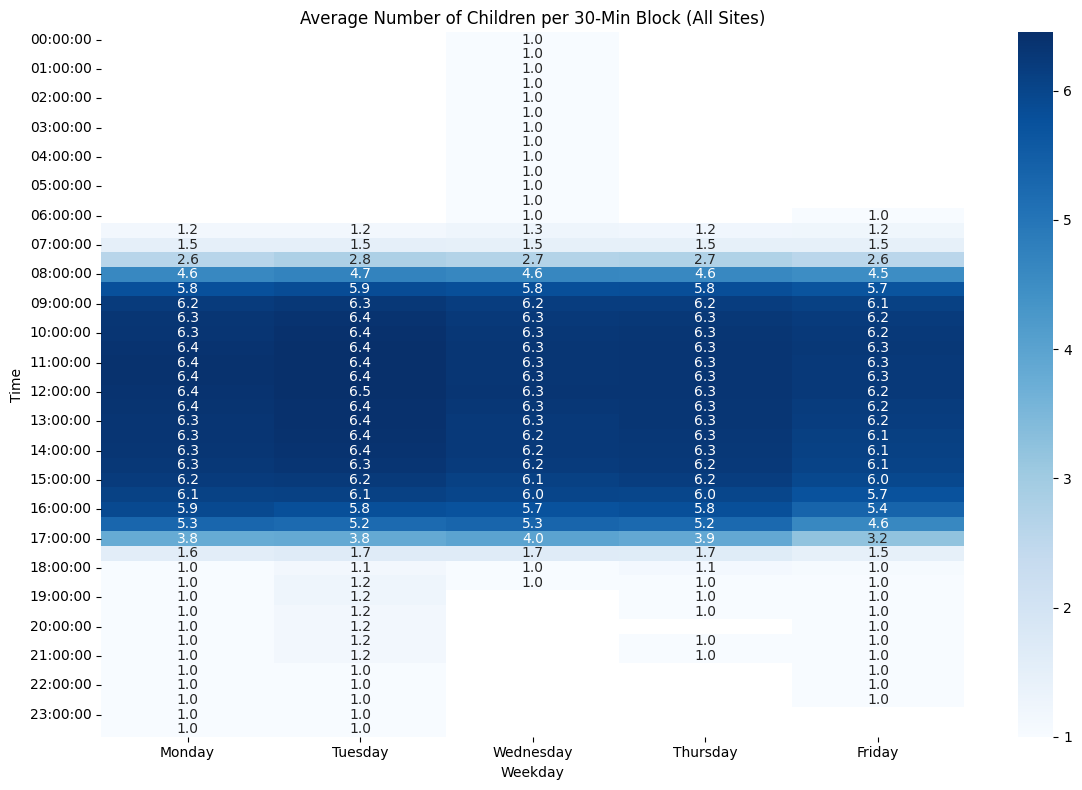

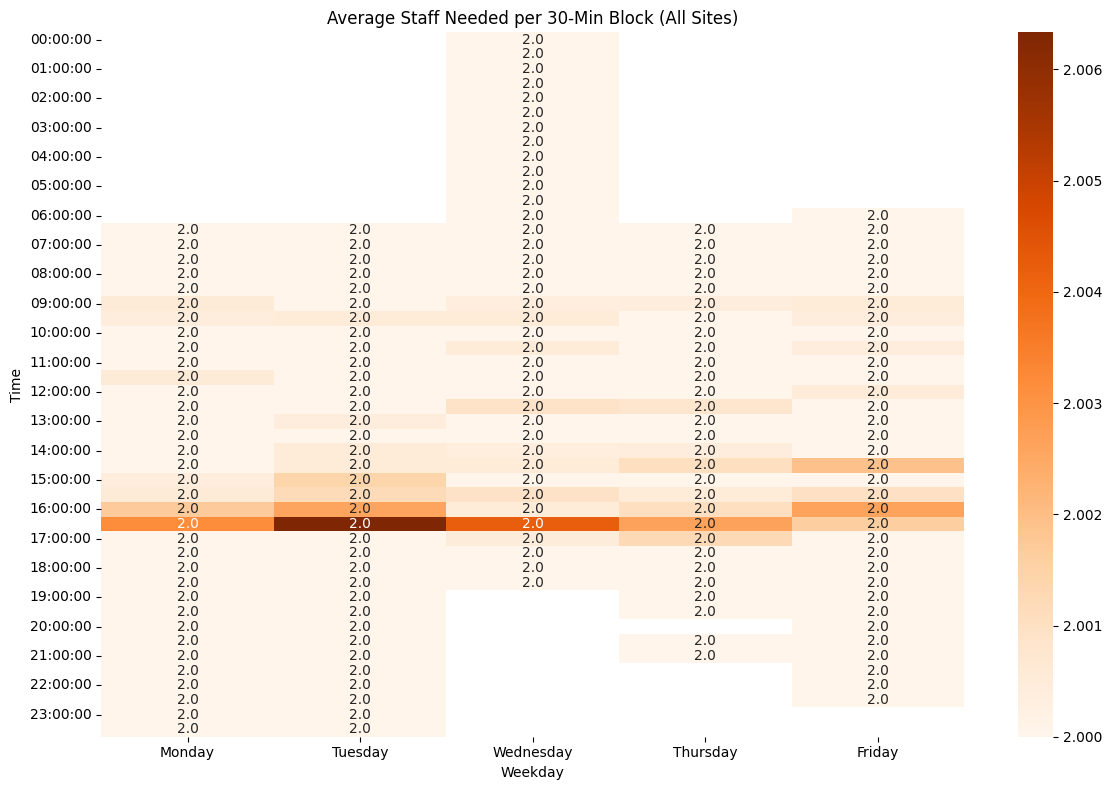

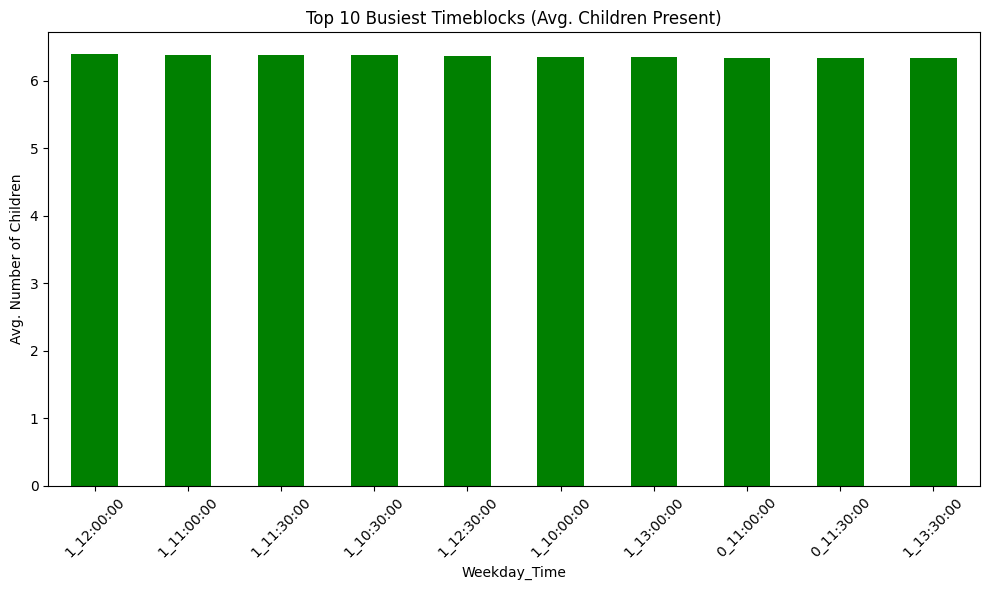

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load merged data
ecec = pd.read_csv("ECEC_2022_to_2025_Merged.csv")
spellman = pd.read_csv("Spellman_2022_to_2025_Merged.csv")

# Add site labels
ecec['Site'] = 'ECEC'
spellman['Site'] = 'Spellman'

# Combine both
combined = pd.concat([ecec, spellman], ignore_index=True)

# Convert date to datetime and extract features
combined['Date'] = pd.to_datetime(combined['Date'])
combined['Weekday'] = combined['Date'].dt.day_name()
combined['Weekday_Num'] = combined['Date'].dt.weekday
combined['Hour'] = combined['Time'].str.slice(0, 2).astype(int)
combined['Timeblock'] = combined['Weekday_Num'].astype(str) + "_" + combined['Time']

# Group by for analysis
summary = combined.groupby(['Site', 'Weekday', 'Time'])[['Num_Children', 'Staff_Needed']].mean().reset_index()

# Pivots for heatmaps
children_pivot = summary.pivot_table(index='Time', columns='Weekday', values='Num_Children')
staff_pivot = summary.pivot_table(index='Time', columns='Weekday', values='Staff_Needed')

# Sort columns as weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
children_pivot = children_pivot[weekday_order]
staff_pivot = staff_pivot[weekday_order]

# Plot: Heatmap of average children
plt.figure(figsize=(12, 8))
sns.heatmap(children_pivot, cmap="Blues", annot=True, fmt=".1f")
plt.title("Average Number of Children per 30-Min Block (All Sites)")
plt.xlabel("Weekday")
plt.ylabel("Time")
plt.tight_layout()
plt.show()

# Plot: Heatmap of staff needed
plt.figure(figsize=(12, 8))
sns.heatmap(staff_pivot, cmap="Oranges", annot=True, fmt=".1f")
plt.title("Average Staff Needed per 30-Min Block (All Sites)")
plt.xlabel("Weekday")
plt.ylabel("Time")
plt.tight_layout()
plt.show()

# Plot: Top 10 busiest timeblocks (by children)
top_blocks = combined.groupby('Timeblock')['Num_Children'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
top_blocks.plot(kind='bar', color='green')
plt.title("Top 10 Busiest Timeblocks (Avg. Children Present)")
plt.ylabel("Avg. Number of Children")
plt.xlabel("Weekday_Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Basic Timeblock Feature Engineering Building on the combined data, here we extract simple time features: convert Date to pandas datetime, derive the weekday name and numeric weekday code, slice the hour from the Time string, and create a Timeblock label (e.g. "2_08:00:00") combining weekday number and clock time. We save this as "Combined_ECEC_Spellman_with_Features.csv", providing a foundation for both descriptive plots and forecasting models.

In [ ]:
import pandas as pd

# Load both cleaned merged files
ecec = pd.read_csv("ECEC_2022_to_2025_Merged.csv")
spellman = pd.read_csv("Spellman_2022_to_2025_Merged.csv")

# Add Site label to each
ecec['Site'] = 'ECEC'
spellman['Site'] = 'Spellman'

# Combine into one DataFrame
combined = pd.concat([ecec, spellman], ignore_index=True)

# Convert 'Date' to datetime
combined['Date'] = pd.to_datetime(combined['Date'])

# Feature Engineering
combined['Weekday'] = combined['Date'].dt.day_name()             # Monday, Tuesday, etc.
combined['Weekday_Num'] = combined['Date'].dt.weekday            # 0–6 (Mon–Sun)
combined['Hour'] = combined['Time'].str.slice(0, 2).astype(int)  # Extract hour from time
combined['Timeblock'] = combined['Weekday_Num'].astype(str) + "_" + combined['Time']  # e.g. '2_08:00:00'

# Optional: Save it for future use
combined.to_csv("Combined_ECEC_Spellman_with_Features.csv", index=False)

# Show preview
print(combined.head())


        Date    Room Age Group      Time  Num_Children  Ratio  Staff_Needed  \
0 2022-01-03  Pre-K1     Pre-K  07:30:00             3     12             2   
1 2022-01-03  Pre-K1     Pre-K  08:00:00             3     12             2   
2 2022-01-03  Pre-K1     Pre-K  08:30:00             3     12             2   
3 2022-01-03  Pre-K1     Pre-K  09:00:00             4     12             2   
4 2022-01-03  Pre-K1     Pre-K  09:30:00             4     12             2   

   Site Weekday  Weekday_Num  Hour   Timeblock  
0  ECEC  Monday            0     7  0_07:30:00  
1  ECEC  Monday            0     8  0_08:00:00  
2  ECEC  Monday            0     8  0_08:30:00  
3  ECEC  Monday            0     9  0_09:00:00  
4  ECEC  Monday            0     9  0_09:30:00  


Advanced Time Features & One-Hot Room Encoding
In this cell, we load the feature-enhanced CSV and generate a full set of time variables: hour, minute, weekday, ISO week number, month, day of year, and a continuous Unix-timestamp for algorithms that like numeric inputs. We also flag U.S. federal holidays using the holidays package, then one-hot-encode the Room column to prepare for machine-learning models. The result is written to "Combined_ECEC_Spellman_Featured_NoLag.csv".

In [ ]:
import pandas as pd
import numpy as np
import holidays

# Load dataset
df = pd.read_csv("Combined_ECEC_Spellman_with_Features.csv")

# Convert to datetime
df['Date'] = pd.to_datetime(df['Date'])
df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'])

# Time-based features
df['hour'] = df['Datetime'].dt.hour
df['minute'] = df['Datetime'].dt.minute
df['weekday'] = df['Datetime'].dt.weekday  # Monday=0, Sunday=6
df['week'] = df['Datetime'].dt.isocalendar().week.astype(int)
df['month'] = df['Datetime'].dt.month
df['dayofyear'] = df['Datetime'].dt.dayofyear
df['timestamp'] = df['Datetime'].astype(np.int64) // 10**9

# Holiday tag using US calendar
us_holidays = holidays.US()
df['is_holiday'] = df['Date'].isin(us_holidays).astype(int)

# One-hot encode Room column
df = pd.get_dummies(df, columns=['Room'], prefix='Room')

# Save processed version (optional)
df.to_csv("Combined_ECEC_Spellman_Featured_NoLag.csv", index=False)
# Show preview
print(combined.head())

        Date    Room Age Group      Time  Num_Children  Ratio  Staff_Needed  \
0 2022-01-03  Pre-K1     Pre-K  07:30:00             3     12             2   
1 2022-01-03  Pre-K1     Pre-K  08:00:00             3     12             2   
2 2022-01-03  Pre-K1     Pre-K  08:30:00             3     12             2   
3 2022-01-03  Pre-K1     Pre-K  09:00:00             4     12             2   
4 2022-01-03  Pre-K1     Pre-K  09:30:00             4     12             2   

   Site Weekday  Weekday_Num  Hour   Timeblock  
0  ECEC  Monday            0     7  0_07:30:00  
1  ECEC  Monday            0     8  0_08:00:00  
2  ECEC  Monday            0     8  0_08:30:00  
3  ECEC  Monday            0     9  0_09:00:00  
4  ECEC  Monday            0     9  0_09:30:00  


**Model Comparison: XGBoost, Random Forest & ARIMA**

In this section, we perform a head-to-head comparison of three forecasting approaches—XGBoost, Random Forest, and Seasonal ARIMA—using a consistent feature set and evaluation window. First, we load the pre-engineered dataset (`Combined_ECEC_Spellman_Featured_NoLag.csv`) and parse `Date` and `Time` into a unified `Datetime` column, then filter to weekdays and sort chronologically. We extract numeric time features (`hour`, `minute`, `weekday`, ISO `week`, `dayofyear`, and a Unix `timestamp`) and include any one-hot–encoded room indicators. We split the last seven weekdays (336 half-hour intervals) off as our test set, reserving the earlier data for training.

For XGBoost and Random Forest, we define parameter grids and run 3-fold cross-validated grid searches optimizing for root-mean-squared error. After finding the best hyperparameters, we fit each model on the full training set and predict on the hold-out intervals. To establish a classical time-series benchmark, we aggregate total staff needed across all rooms into a single series, fit an ARIMA(5,1,0) model, and forecast the same 336-interval horizon.

We then evaluate each method using three metrics—MAE, RMSE, and MAPE—via a reusable `eval_metrics()` function that guards against division by zero. Finally, we compile the scores into a comparison table, rounding to two decimal places, and print it so you can immediately see which approach delivers the most accurate forecasts for your staffing data.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")

# 1. Load and preprocess
df = pd.read_csv("/content/Combined_ECEC_Spellman_Featured_NoLag.csv")
df['Date']     = pd.to_datetime(df['Date'])
df['Datetime'] = pd.to_datetime(df['Date'].dt.strftime("%Y-%m-%d") + " " + df['Time'])
# keep weekdays only
df = df[df['Weekday_Num'] < 5].sort_values("Datetime")

# 2. Create numeric features
df['hour']      = df['Datetime'].dt.hour
df['minute']    = df['Datetime'].dt.minute
df['weekday']   = df['Datetime'].dt.weekday
df['week']      = df['Datetime'].dt.isocalendar().week.astype(int)
df['dayofyear'] = df['Datetime'].dt.dayofyear
df['ts']        = df['Datetime'].astype(np.int64) // 10**9

# 3. Define X, y and train/test split
feature_cols = ['hour','minute','weekday','week','dayofyear','ts'] + \
               [c for c in df.columns if c.startswith("Room_")]  # include one‐hot rooms if present
X = df[feature_cols]
y = df['Staff_Needed']
# last 7 weekdays = 7*48 intervals
test_size = 336
X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

# 4. XGBoost with GridSearchCV
xgb_grid = {
    'n_estimators': [100,200],
    'max_depth':    [3,5],
    'learning_rate':[0.05,0.1],
    'subsample':    [0.8],
    'colsample_bytree':[0.8]
}
xgb_gs = GridSearchCV(
    XGBRegressor(random_state=42),
    xgb_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
xgb_gs.fit(X_train, y_train)
xgb_pred = xgb_gs.best_estimator_.predict(X_test)

# 5. Random Forest with GridSearchCV
rf_grid = {
    'n_estimators': [100,200],
    'max_depth':    [10,20],
    'min_samples_split':[2,5]
}
rf_gs = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
rf_gs.fit(X_train, y_train)
rf_pred = rf_gs.best_estimator_.predict(X_test)

# 6. ARIMA baseline on aggregated total staff series
series = df.set_index('Datetime')['Staff_Needed'].resample('30T').sum().iloc[:-test_size]
arima_mod = ARIMA(series, order=(5,1,0)).fit()
arima_pred = arima_mod.forecast(steps=test_size)

# 7. Evaluate
def eval_metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred)/np.maximum(y_true,1))) * 100
    return mae, rmse, mape

xgb_scores   = eval_metrics(y_test,        xgb_pred)
rf_scores    = eval_metrics(y_test,        rf_pred)
arima_scores = eval_metrics(y_test.values, arima_pred.values)

# 8. Show comparison
comp = pd.DataFrame([
    ['XGBoost',       *[round(v,2) for v in xgb_scores]],
    ['Random Forest', *[round(v,2) for v in rf_scores]],
    ['ARIMA',         *[round(v,2) for v in arima_scores]]
], columns=['Model','MAE','RMSE','MAPE (%)'])

print(comp.to_string(index=False))

        Model   MAE  RMSE  MAPE (%)
      XGBoost  0.01  0.08      0.32
Random Forest  0.01  0.08      0.34
        ARIMA 10.40 10.40    518.68


Decode One-Hot Encodings Back to Room Names
Since one-hot columns (Room_*) aren’t human-readable in final outputs, this cell reloads the “NoLag” file, finds all Room_ columns, and collapses them back into a single Room label by taking the idxmax() across the dummies and stripping the "Room_" prefix. We then save "Combined_ECEC_Spellman_DecodedRoom.csv". This step ensures our forecast outputs remain interpretable at the room level.

In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv("/content/Combined_ECEC_Spellman_Featured_NoLag.csv")

# Identify all room columns (those that start with 'Room_')
room_columns = [col for col in df.columns if col.startswith("Room_")]

# Create a new column 'Room' by extracting the room name from the one-hot columns
df['Room'] = df[room_columns].idxmax(axis=1).str.replace('Room_', '', regex=False)

# Optional: Drop the original one-hot columns
# df.drop(columns=room_columns, inplace=True)

# Save or inspect
print(df[['Room']].head(30))
df.to_csv("Combined_ECEC_Spellman_DecodedRoom.csv", index=False)

      Room
0   Pre-K1
1   Pre-K1
2   Pre-K1
3   Pre-K1
4   Pre-K1
5   Pre-K1
6   Pre-K1
7   Pre-K1
8   Pre-K1
9   Pre-K1
10  Pre-K1
11  Pre-K1
12  Pre-K1
13  Pre-K1
14  Pre-K1
15  Pre-K1
16  Pre-K1
17  Pre-K1
18  Pre-K1
19  Pre-K1
20  Pre-K2
21  Pre-K2
22  Pre-K2
23  Pre-K2
24  Pre-K2
25  Pre-K2
26  Pre-K2
27  Pre-K2
28  Pre-K2
29  Pre-K2


In this section, we begin by importing Pandas for data handling and Matplotlib/Seaborn for visualization, then load the fully decoded dataset (`Combined_ECEC_Spellman_DecodedRoom.csv`). We convert the `Date` column into a true datetime type, extract the weekday name and number, and pull the hour from the existing `Time` string—finally concatenating weekday and time into a single `Timeblock` identifier. Next, we print overall descriptive statistics to get a feel for the data distribution, and compute summary tables: total record counts by site and weekday, and the average number of children and staff needed at each site. We then identify the top 10 half-hour blocks with the highest average child counts. For visual exploration, we pivot the data into weekday-by-time matrices and render two heatmaps—one showing average children per block, the other showing staff needed—followed by a bar chart highlighting the busiest timeblocks across the week.



📊 Descriptive Stats:
                                  Date Age Group      Time   Num_Children  \
count                          222832    222832    222832  222832.000000   
unique                            NaN         5        48            NaN   
top                               NaN   Toddler  12:00:00            NaN   
freq                              NaN     68855     10919            NaN   
mean    2023-12-05 08:32:57.712357376       NaN       NaN       5.558133   
min               2022-01-03 00:00:00       NaN       NaN       1.000000   
25%               2023-04-20 00:00:00       NaN       NaN       2.000000   
50%               2024-01-31 00:00:00       NaN       NaN       5.000000   
75%               2024-08-19 00:00:00       NaN       NaN       8.000000   
max               2025-02-28 00:00:00       NaN       NaN      23.000000   
std                               NaN       NaN       NaN       3.819551   

                Ratio   Staff_Needed    Site    Weekday    Weekd

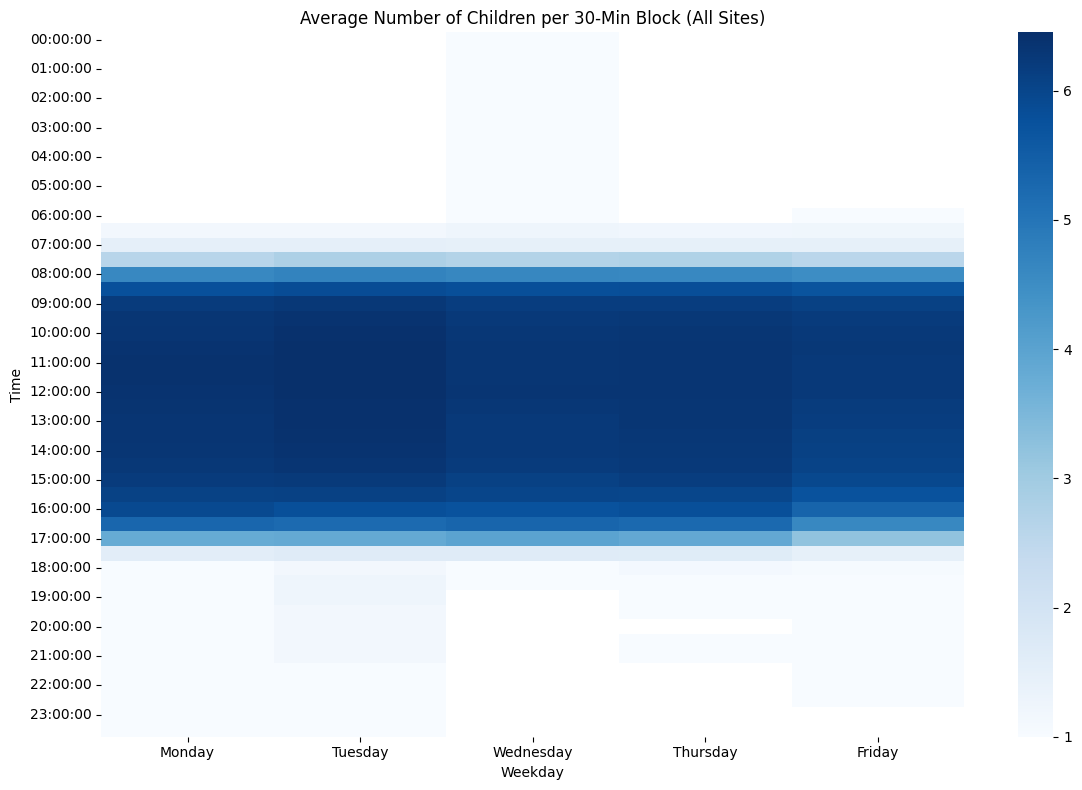

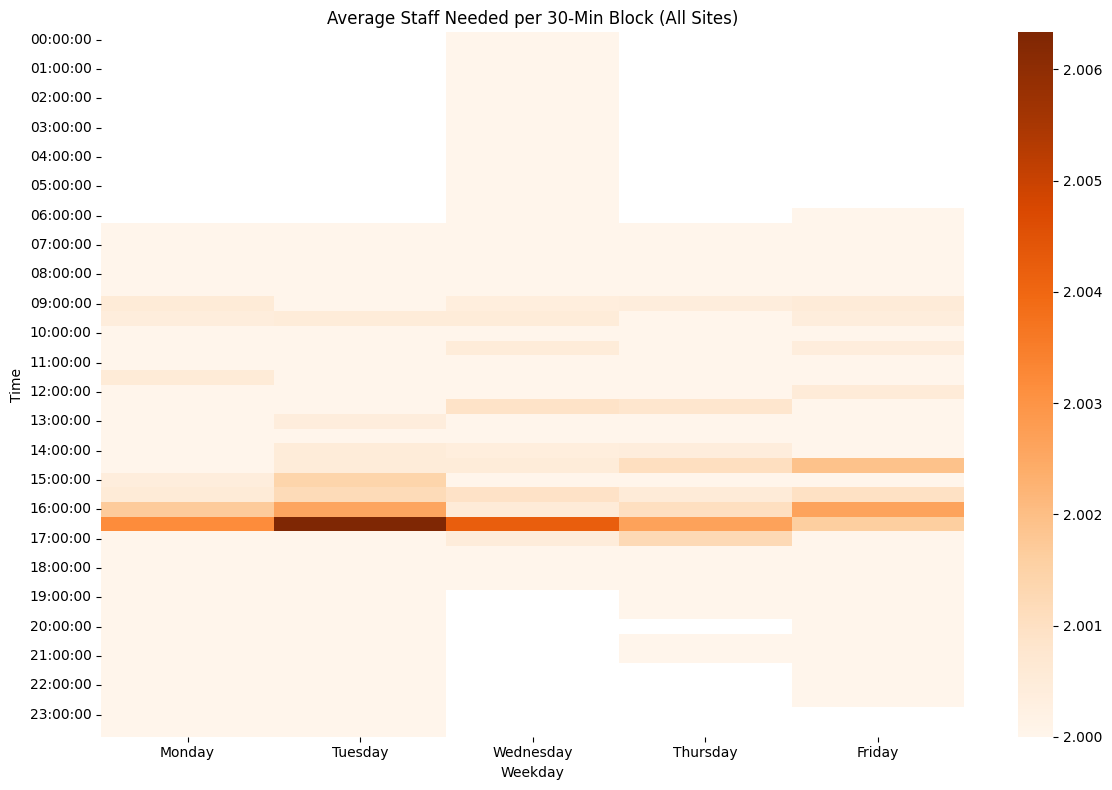

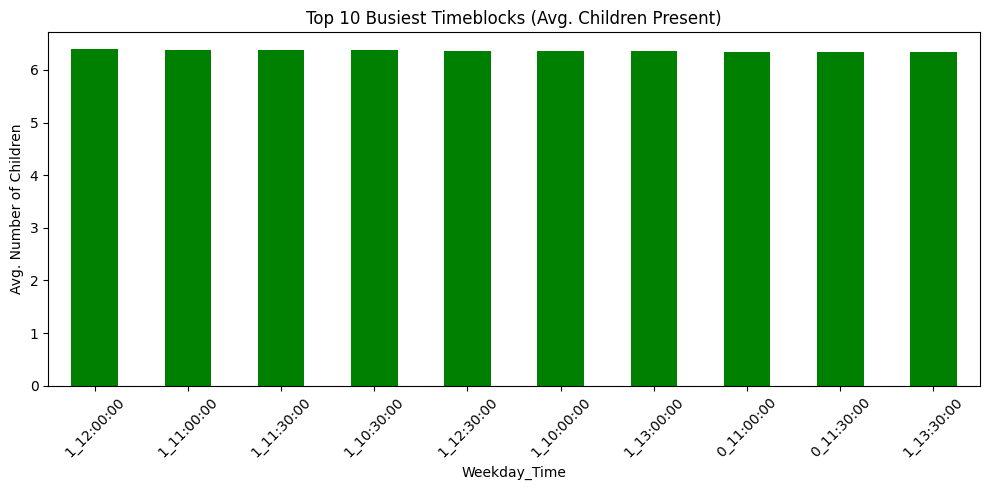

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load Renamed Data ---
combined = pd.read_csv('/content/Combined_ECEC_Spellman_DecodedRoom.csv')

# --- Convert Date column ---
combined['Date'] = pd.to_datetime(combined['Date'])

# --- Feature Engineering (in case it's not already there) ---
combined['Weekday'] = combined['Date'].dt.day_name()
combined['Weekday_Num'] = combined['Date'].dt.weekday
combined['Hour'] = combined['Time'].str.slice(0, 2).astype(int)
combined['Timeblock'] = combined['Weekday_Num'].astype(str) + "_" + combined['Time']

# --- Descriptive Stats ---
print("\n📊 Descriptive Stats:\n", combined.describe(include='all'))

# --- Record Count by Site and Weekday ---
site_day_counts = combined.groupby(['Site', 'Weekday']).size().reset_index(name='Record Count')
print("\n📅 Record Counts by Site and Weekday:\n", site_day_counts)

# --- Average Children and Staff per Site ---
avg_site = combined.groupby('Site')[['Num_Children', 'Staff_Needed']].mean().reset_index()
print("\n👶 Avg Children & Staff by Site:\n", avg_site)

# --- Top 10 Busiest Timeblocks ---
top_blocks = combined.groupby('Timeblock')['Num_Children'].mean().sort_values(ascending=False).head(10)
print("\n🔥 Top 10 Busiest Timeblocks:\n", top_blocks)

# --- Weekly Summary for Heatmaps ---
summary = combined.groupby(['Site', 'Weekday', 'Time'])[['Num_Children', 'Staff_Needed']].mean().reset_index()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# --- Children Heatmap ---
plt.figure(figsize=(12, 8))
children_pivot = summary.pivot_table(index='Time', columns='Weekday', values='Num_Children')
children_pivot = children_pivot[weekday_order]
sns.heatmap(children_pivot, cmap="Blues", annot=False)
plt.title("Average Number of Children per 30-Min Block (All Sites)")
plt.xlabel("Weekday")
plt.ylabel("Time")
plt.tight_layout()
plt.show()

# --- Staff Heatmap ---
plt.figure(figsize=(12, 8))
staff_pivot = summary.pivot_table(index='Time', columns='Weekday', values='Staff_Needed')
staff_pivot = staff_pivot[weekday_order]
sns.heatmap(staff_pivot, cmap="Oranges", annot=False)
plt.title("Average Staff Needed per 30-Min Block (All Sites)")
plt.xlabel("Weekday")
plt.ylabel("Time")
plt.tight_layout()
plt.show()

# --- Top Timeblocks Bar Chart ---
plt.figure(figsize=(10, 5))
top_blocks.plot(kind='bar', color='green')
plt.title("Top 10 Busiest Timeblocks (Avg. Children Present)")
plt.ylabel("Avg. Number of Children")
plt.xlabel("Weekday_Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Exploratory Descriptive & Heatmap Visualization**

In this section, we load the fully decoded staffing dataset (`Combined_ECEC_Spellman_DecodedRoom.csv`) and prepare it for descriptive analysis. First, we import Pandas for data manipulation and Matplotlib/Seaborn for plotting. We parse the `Date` column into a datetime type, extract both the weekday name and its numeric code, pull out the hour from the existing `Time` string, and combine weekday and time into a single `Timeblock` identifier. We then display overall descriptive statistics to understand the distributions, and compute summary tables: total record counts by site and weekday, as well as the average number of children and staff needed per site. Next, we determine the top 10 half-hour blocks with the highest average child counts. For visual insights, we pivot the data into weekday-by-time matrices and render two heatmaps—one for average children per block and another for staff needed—followed by a bar chart that highlights the busiest timeblocks across the week.


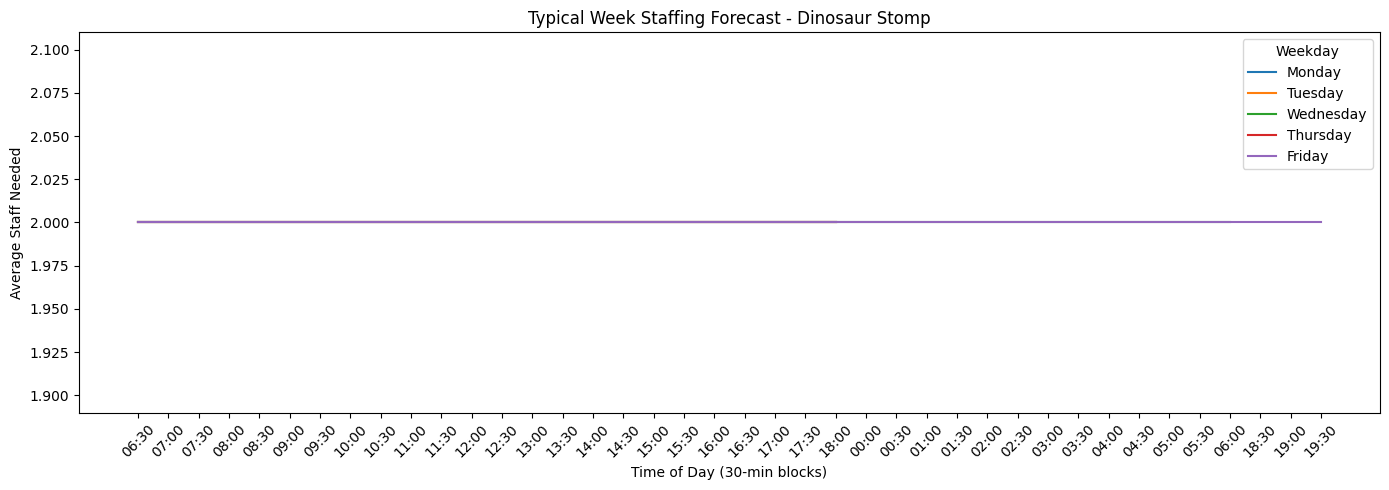

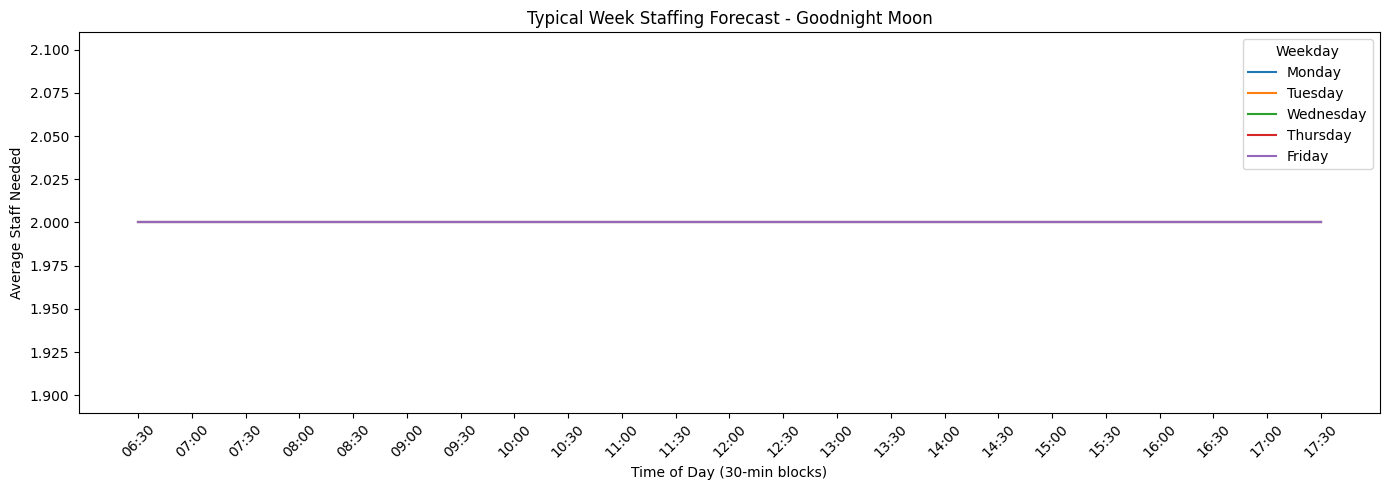

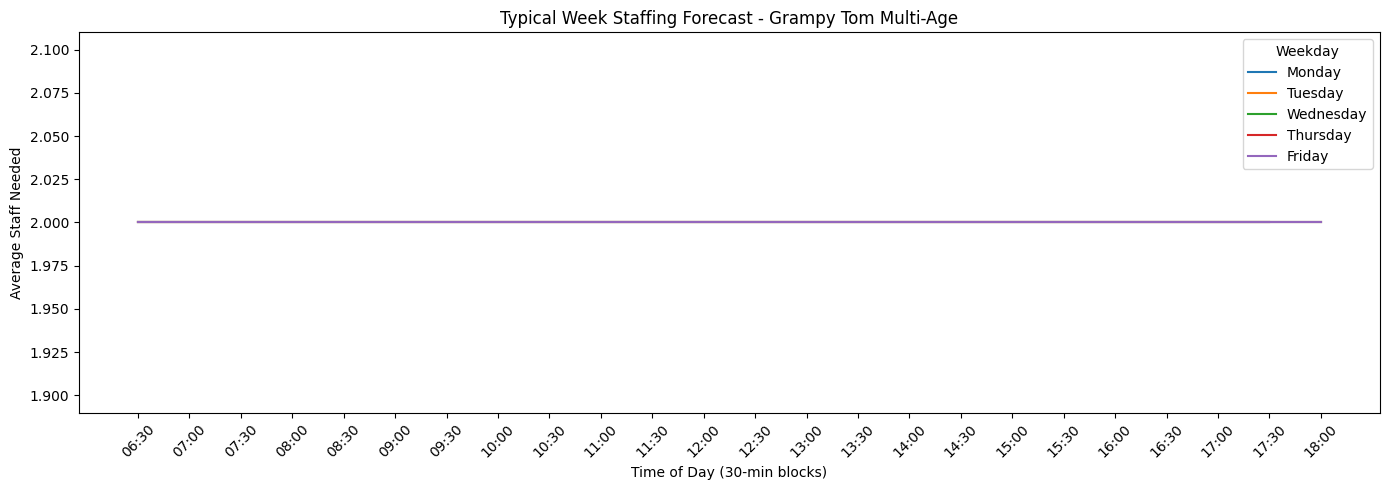

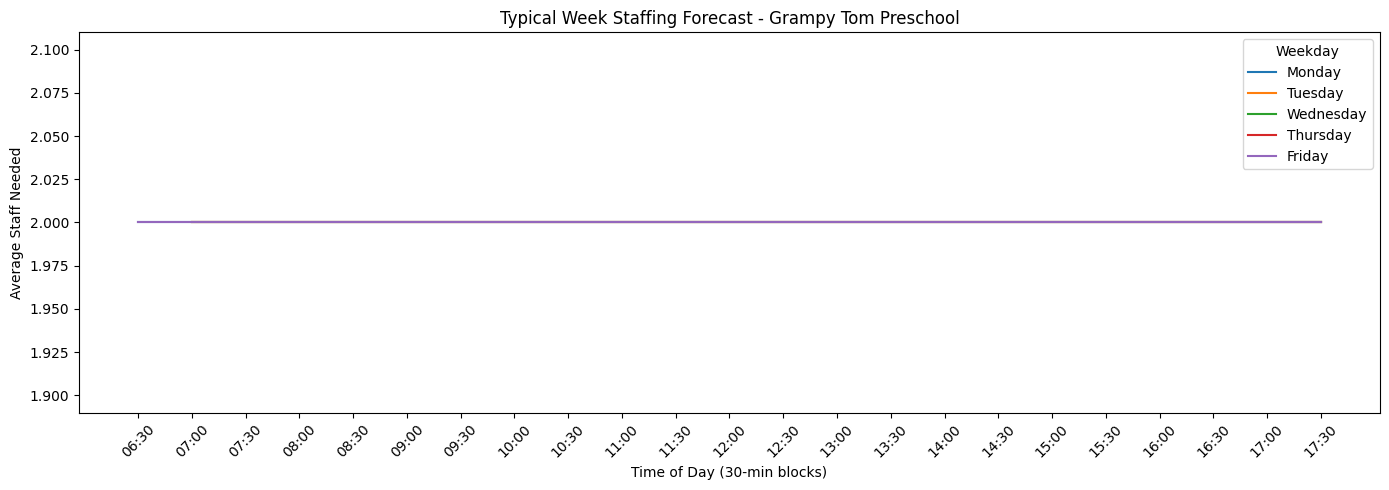

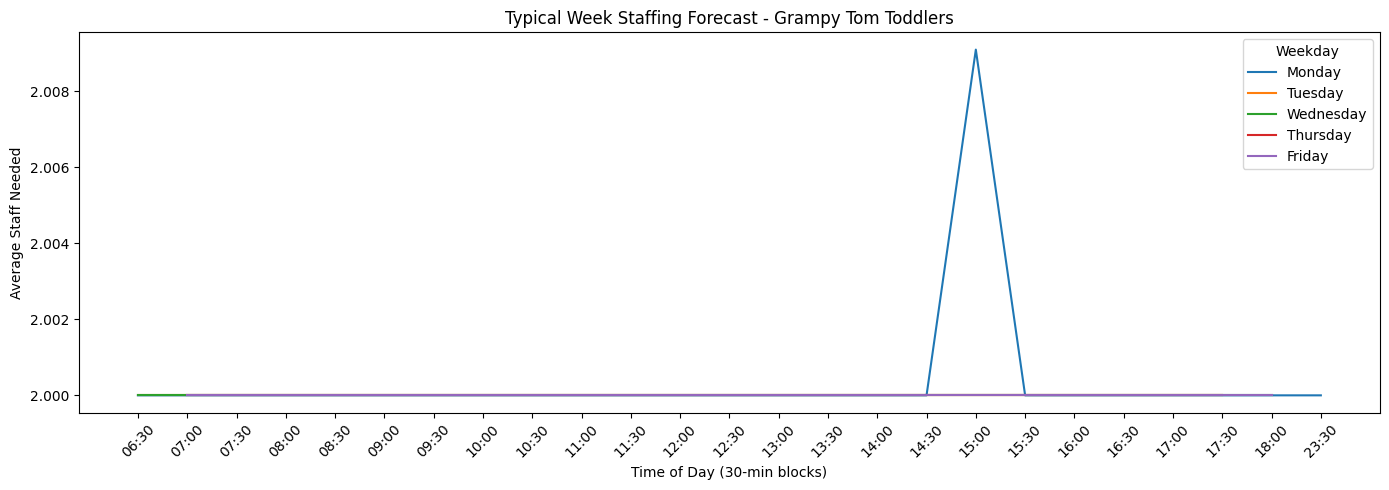

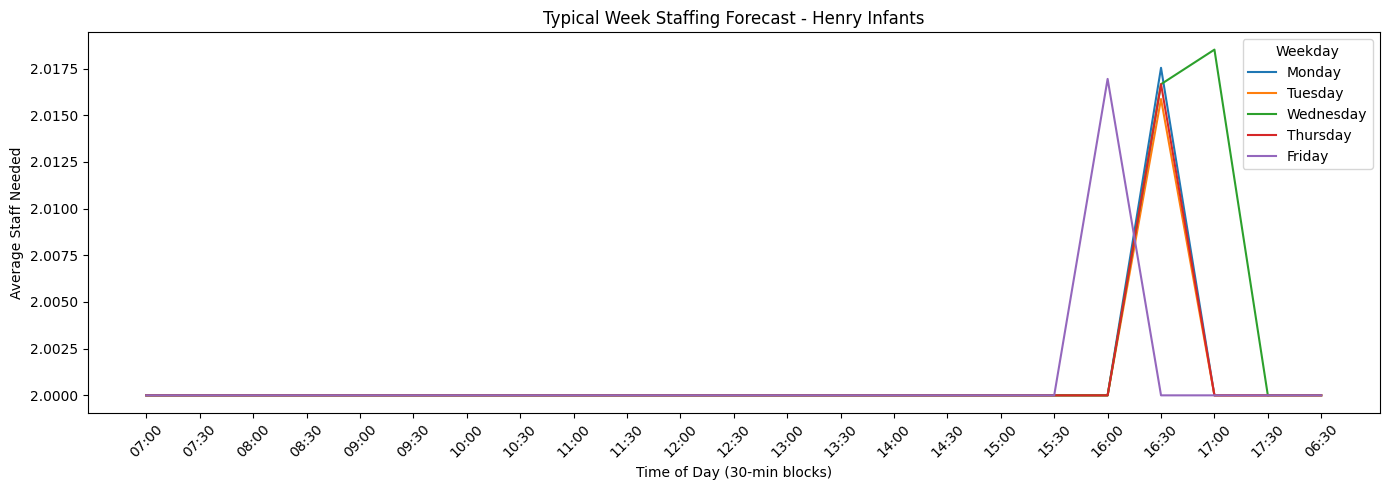

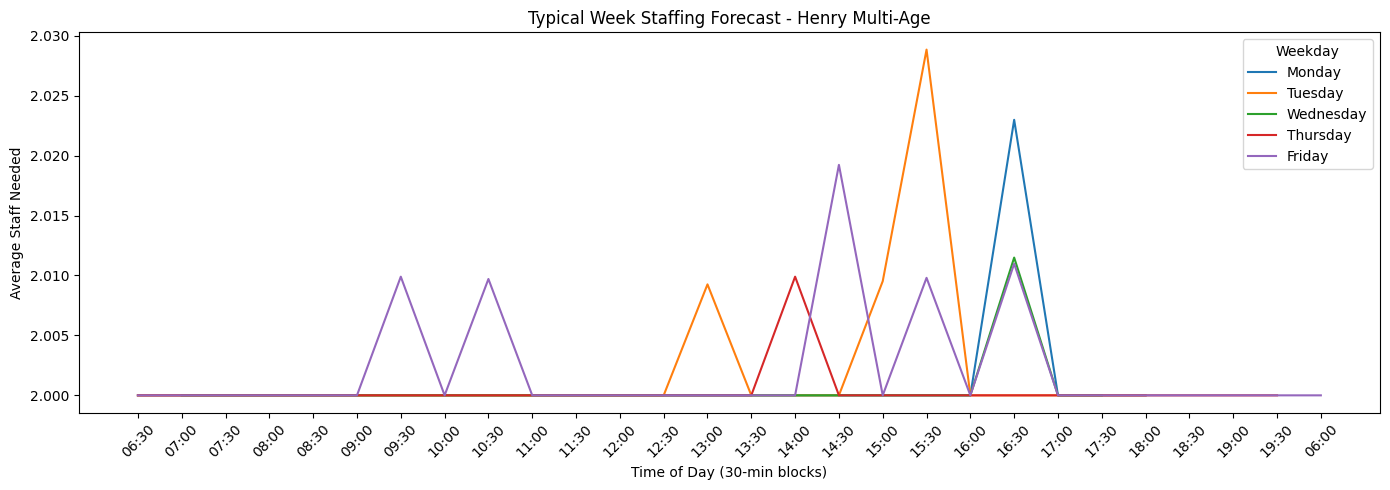

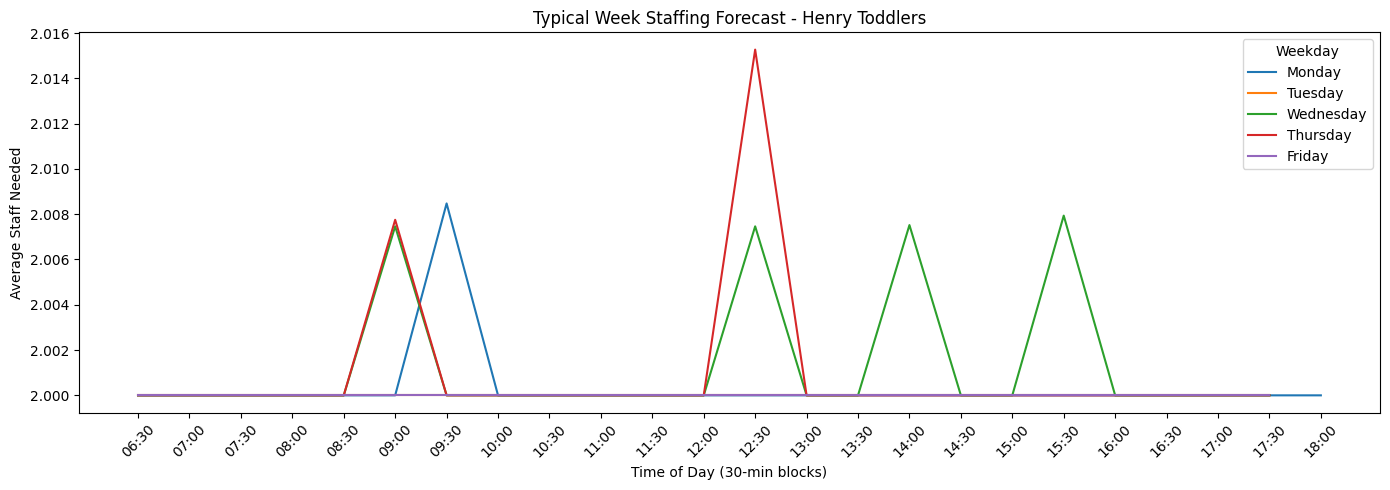

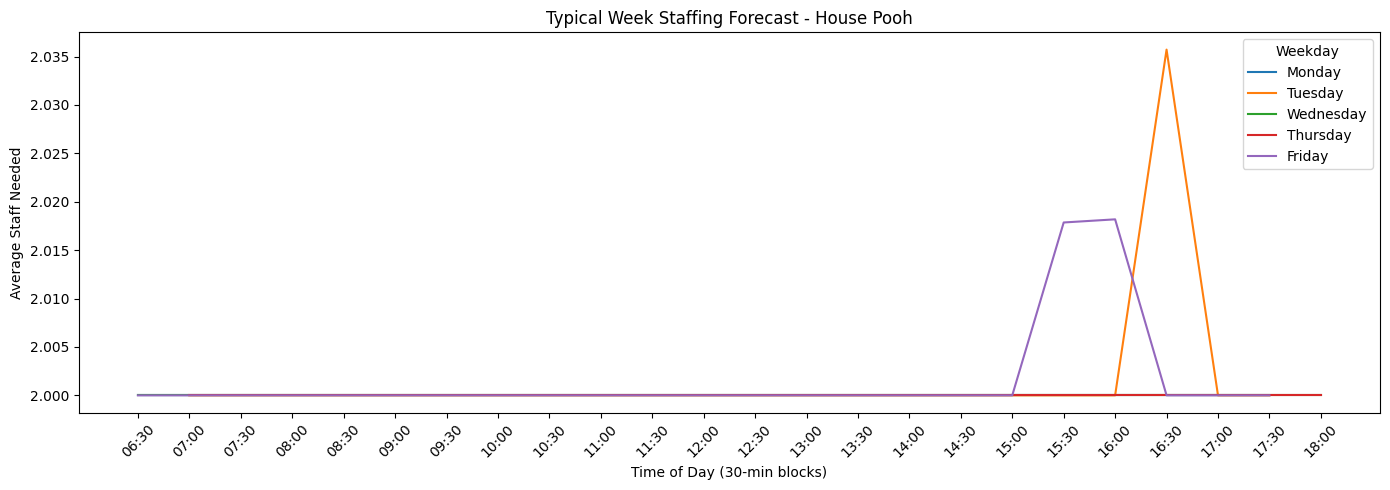

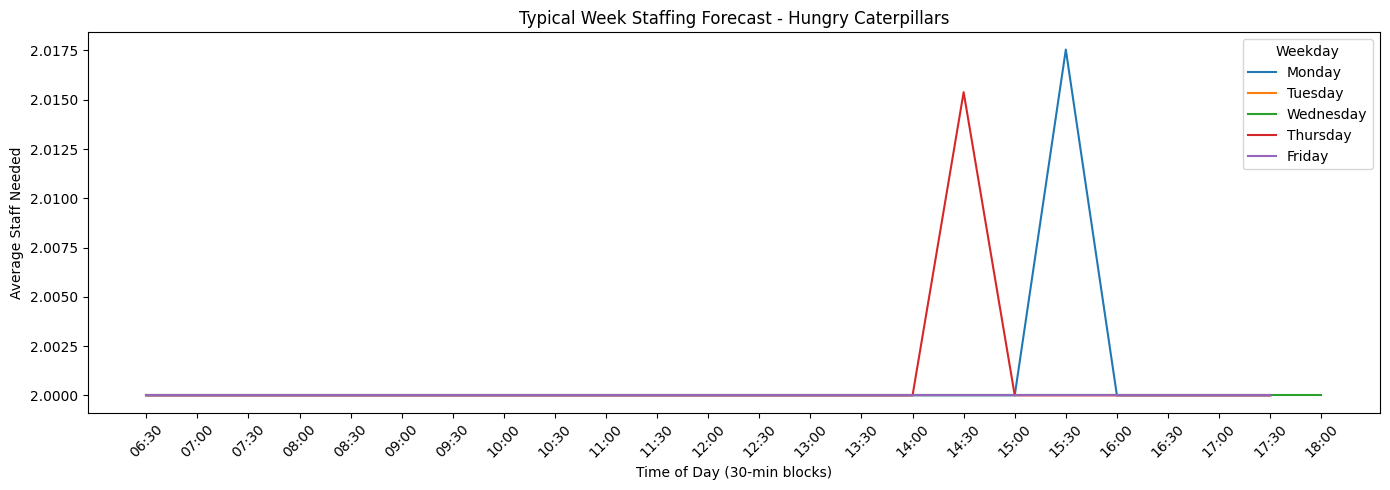

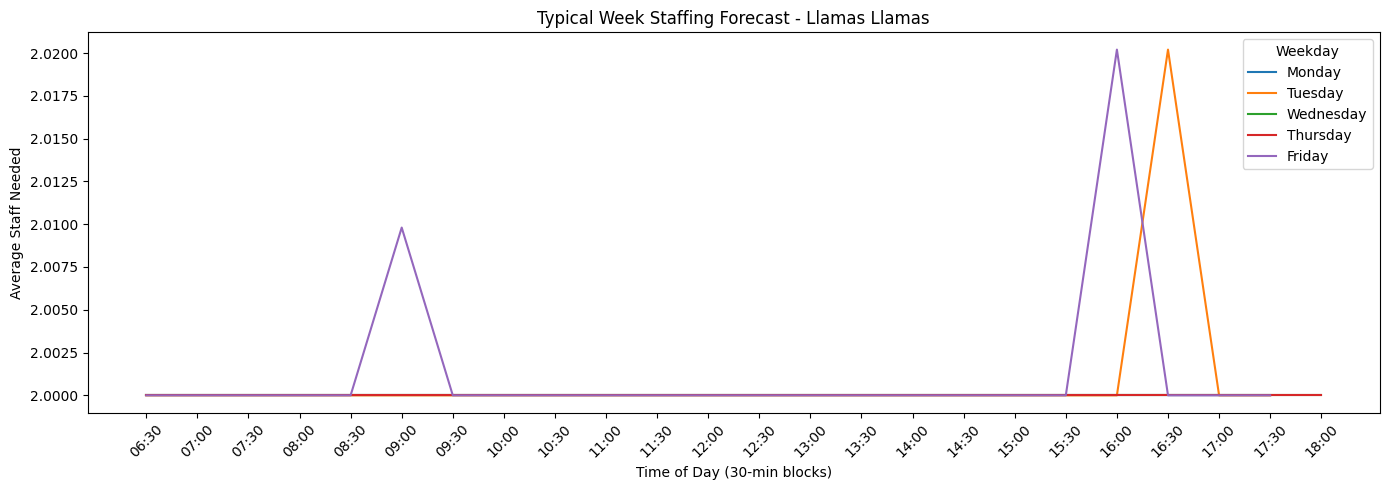

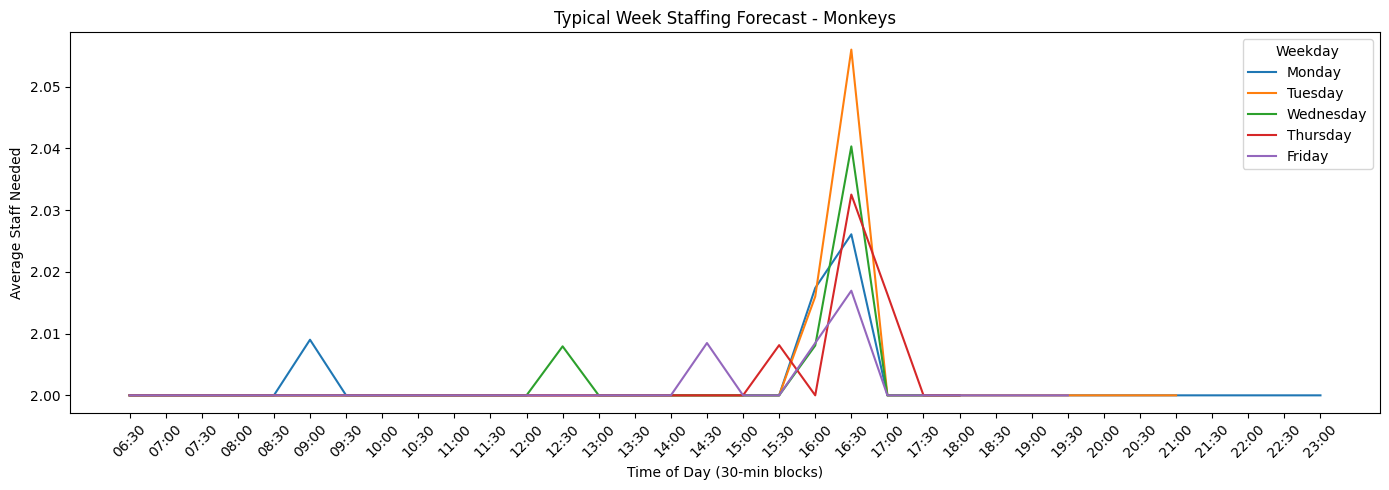

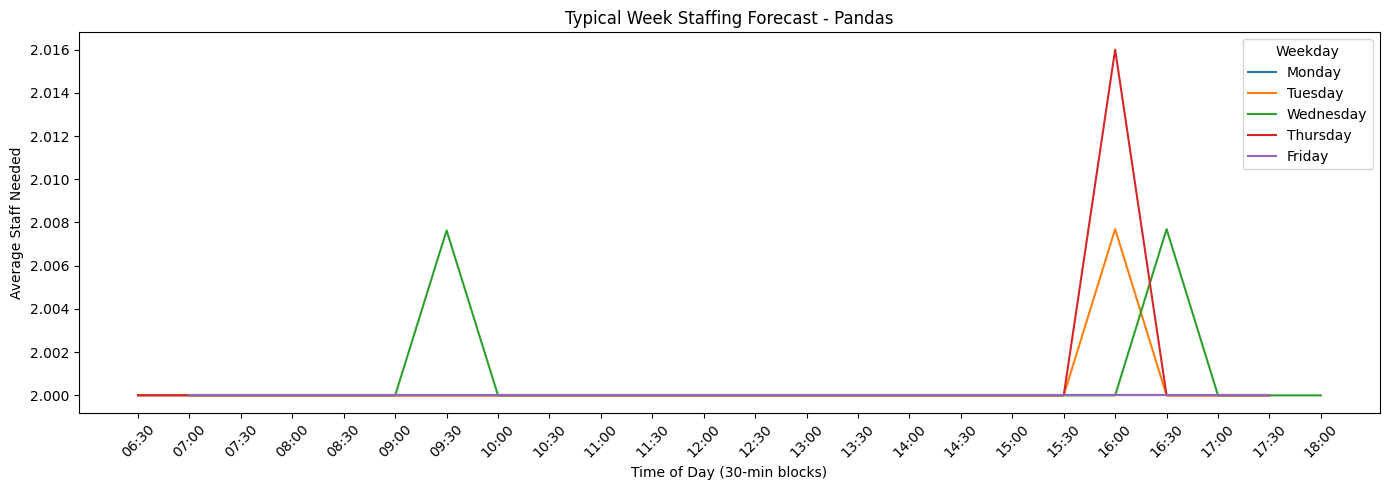

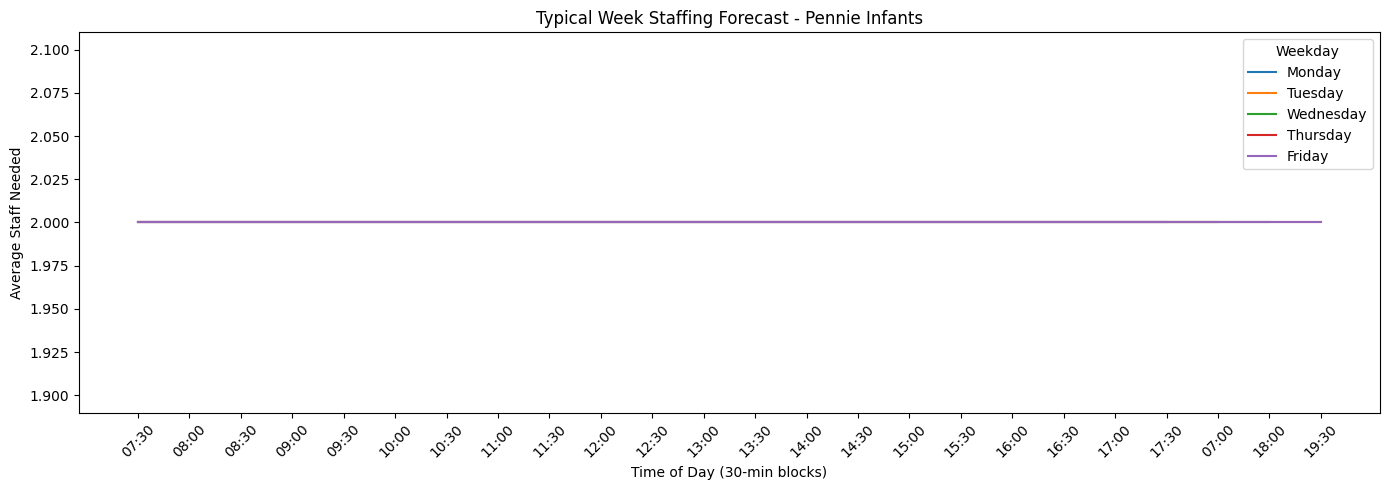

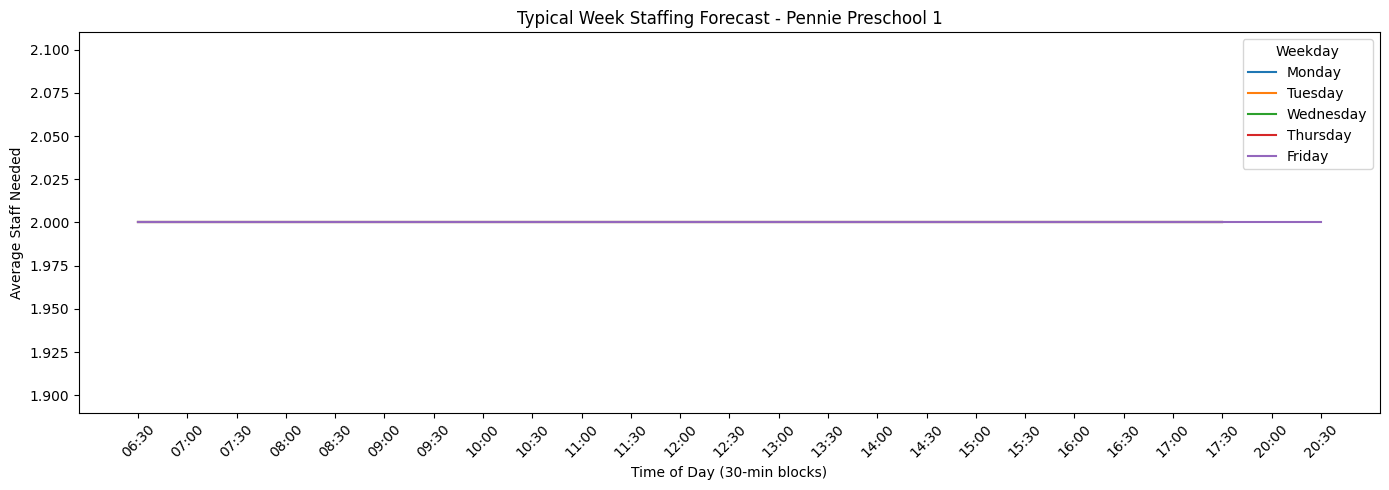

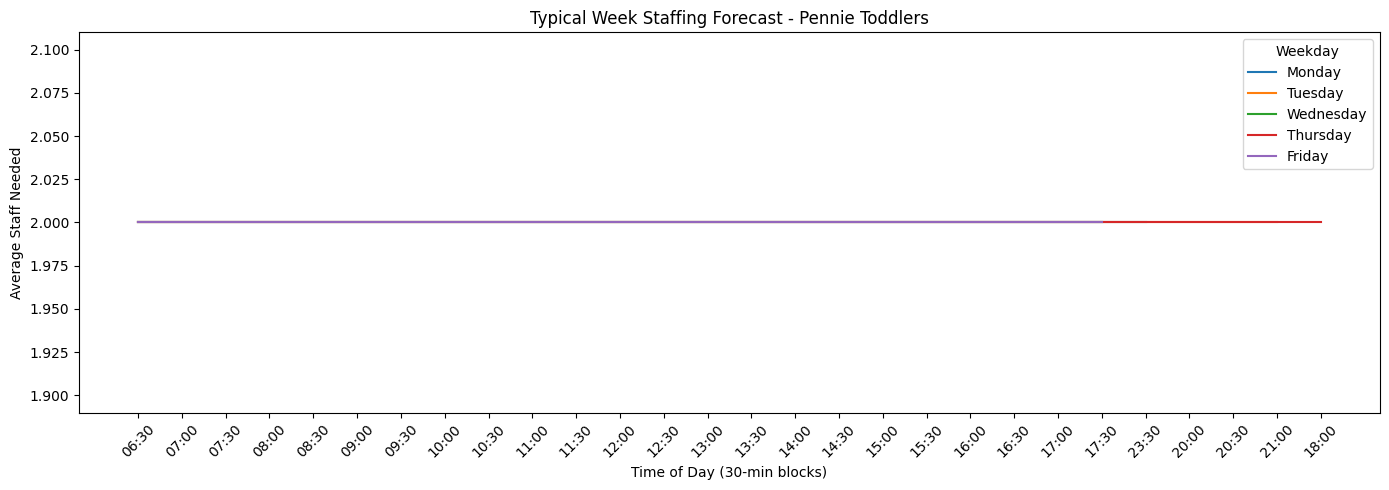

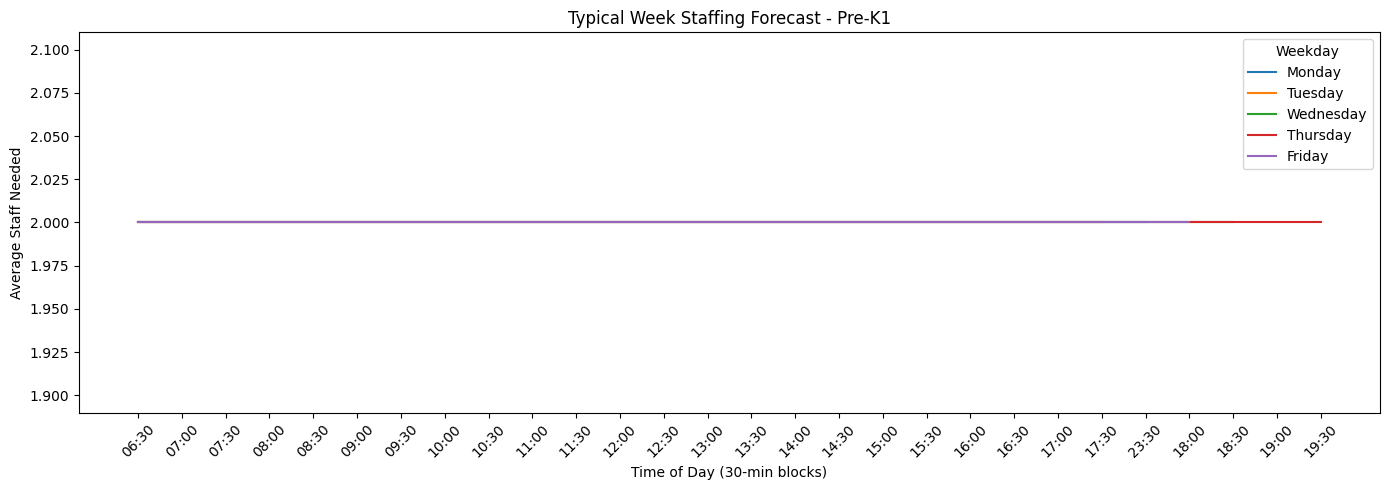

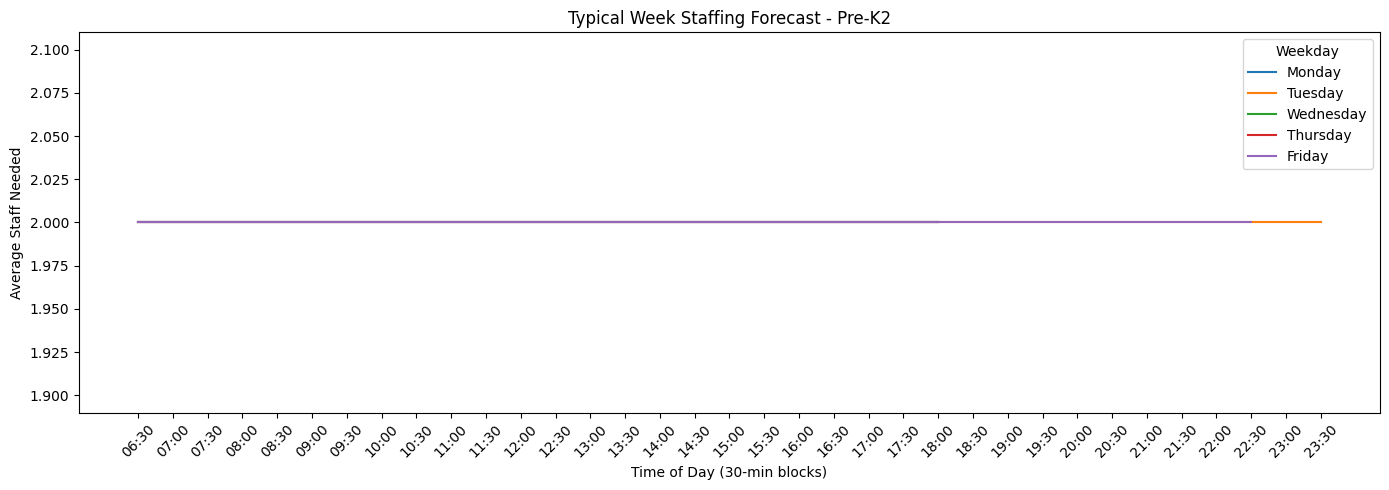

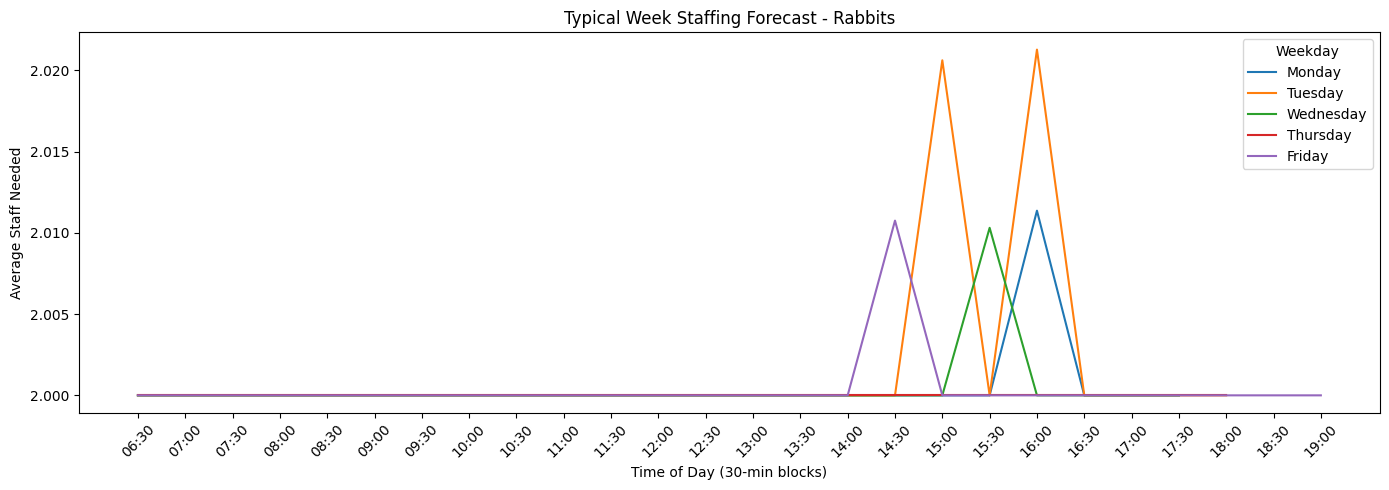

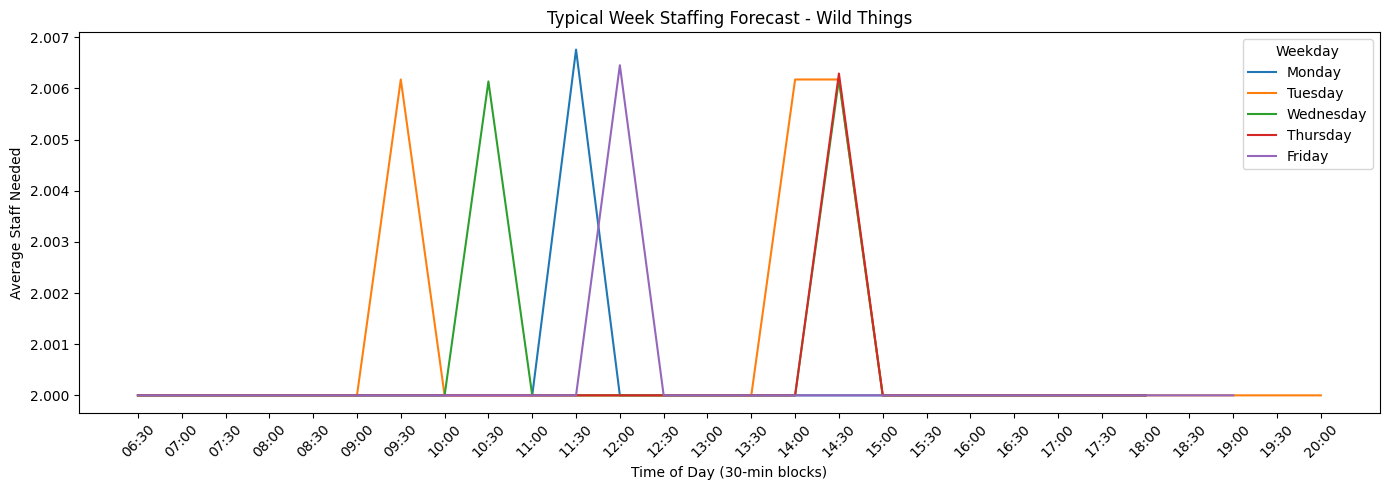

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("Combined_ECEC_Spellman_DecodedRoom.csv")

# Preprocessing
df['Date'] = pd.to_datetime(df['Date'])
df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'])
df['Weekday'] = df['Date'].dt.day_name()
df['Hour_Min'] = df['Datetime'].dt.strftime('%H:%M')

# Filter for weekdays only (Mon-Fri)
df = df[df['Weekday'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]

# Group to compute "typical week"
typical_week = df.groupby(['Room', 'Weekday', 'Hour_Min'])['Staff_Needed'].mean().reset_index()

# Define order of weekdays
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
typical_week['Weekday'] = pd.Categorical(typical_week['Weekday'], categories=weekday_order, ordered=True)
typical_week = typical_week.sort_values(['Room', 'Weekday', 'Hour_Min'])

# Plot per room
rooms = typical_week['Room'].unique()
for room in rooms:
    plt.figure(figsize=(14, 5))
    sns.lineplot(
        data=typical_week[typical_week['Room'] == room],
        x='Hour_Min', y='Staff_Needed', hue='Weekday', palette='tab10'
    )
    plt.title(f"Typical Week Staffing Forecast - {room}")
    plt.xlabel("Time of Day (30-min blocks)")
    plt.ylabel("Average Staff Needed")
    plt.xticks(rotation=45)
    plt.legend(title='Weekday')
    plt.tight_layout()
    plt.show()


**Typical-Week Room-Level Staffing Profiles**

In this section, we load the fully decoded dataset and prepare it to visualize average attendance and staffing patterns for each room across a “typical” Monday–Friday week. After reading the CSV, we convert the `Date` column to datetime, extract `Weekday` (name) and `Weekday_Num` (0–6), pull out the hour from the `Time` string, and combine weekday number and time into a `Timeblock` label. We then group the data by `Room`, `Weekday`, and `Time`, calculating the mean number of children (`Num_Children`) and required staff (`Staff_Needed`) in each half-hour slot.

To spotlight the busiest areas, we identify the top rooms by record count and loop through them to plot two sets of line charts:

1. **Average Children per Room:** A multi-line plot showing the mean headcount at each time slot, with a separate line for each weekday, so you can see how occupancy rises and falls from Monday through Friday.
2. **Average Staff Needed per Room:** A similar plot illustrating how staffing requirements vary over the week, directly reflecting the occupancy trends.

These visualizations provide a clear “stereotype” weekly schedule for each room, making it easy to anticipate demand peaks and plan staffing accordingly.


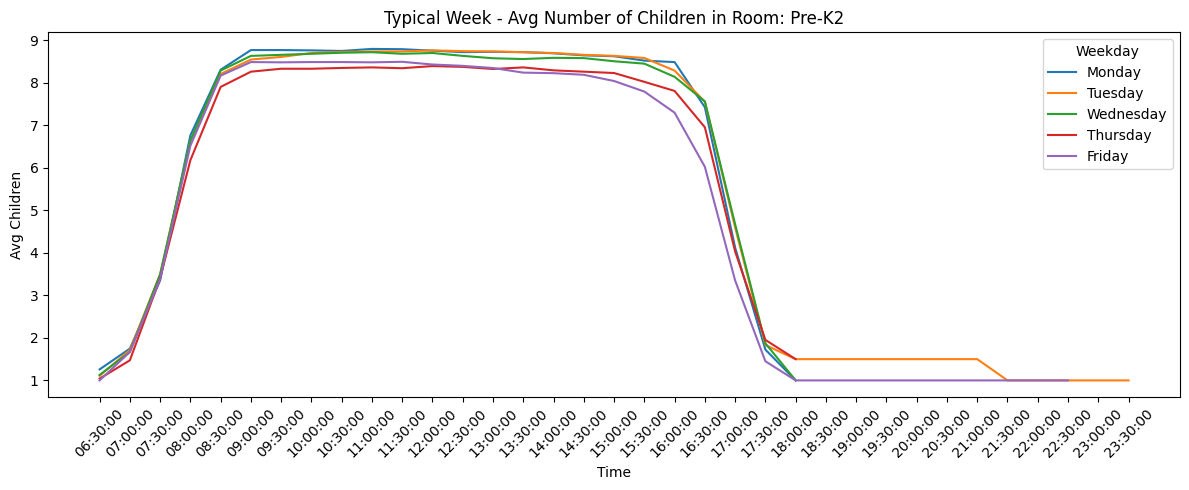

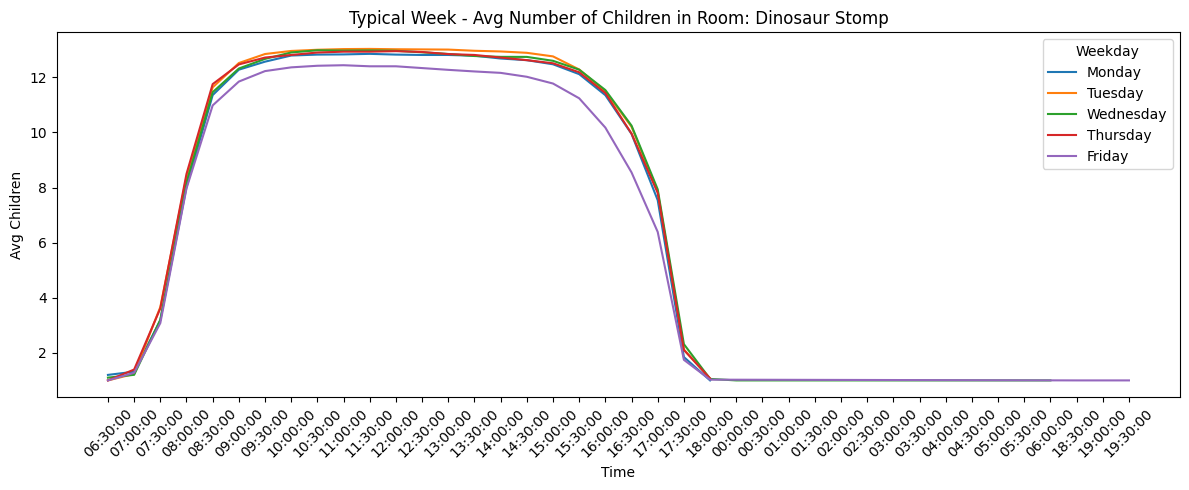

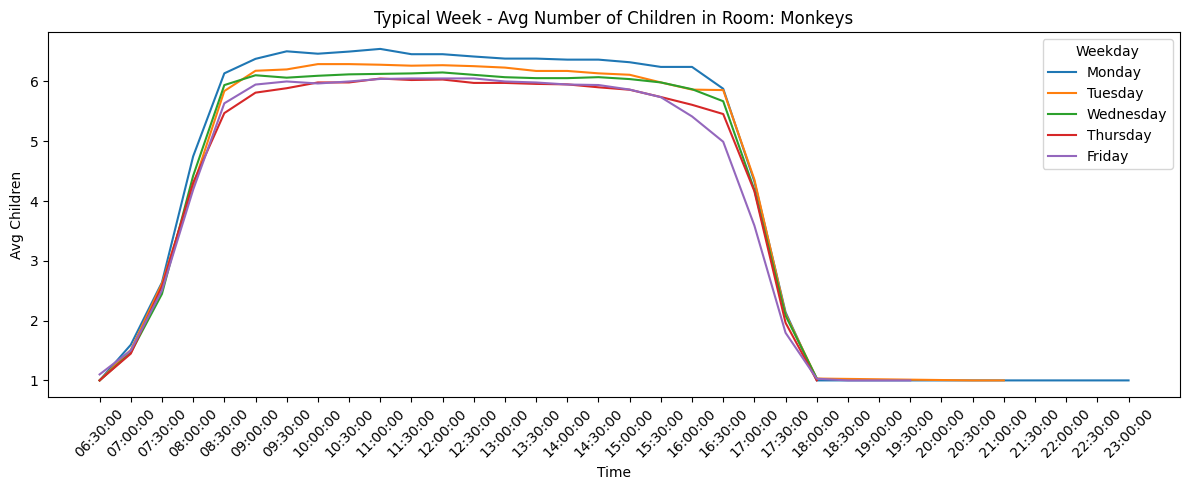

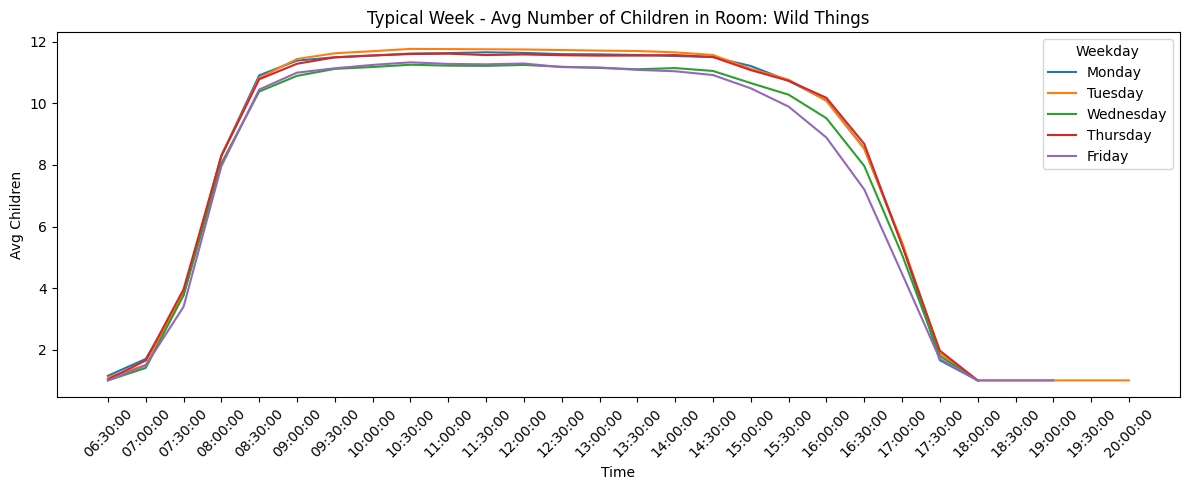

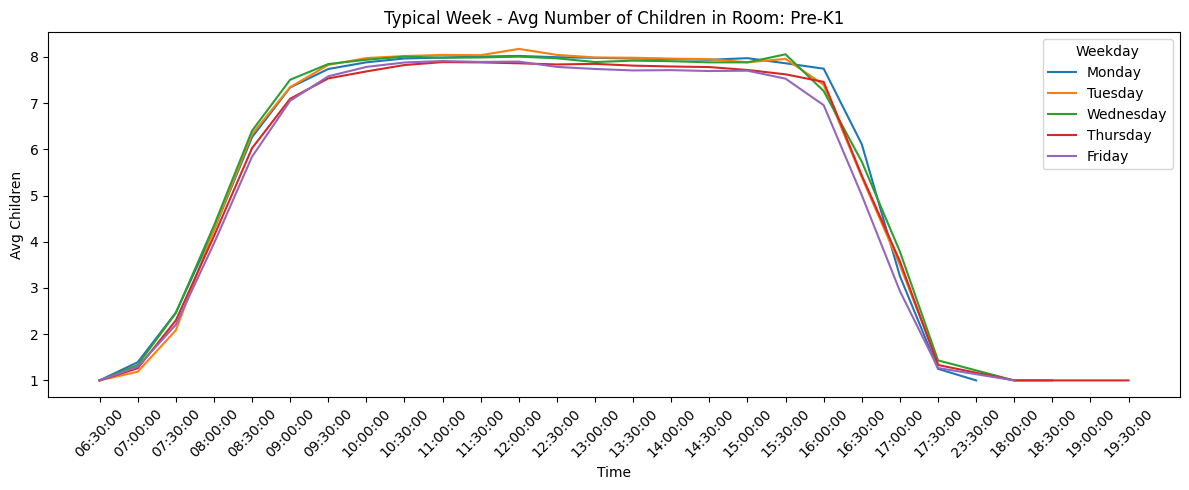

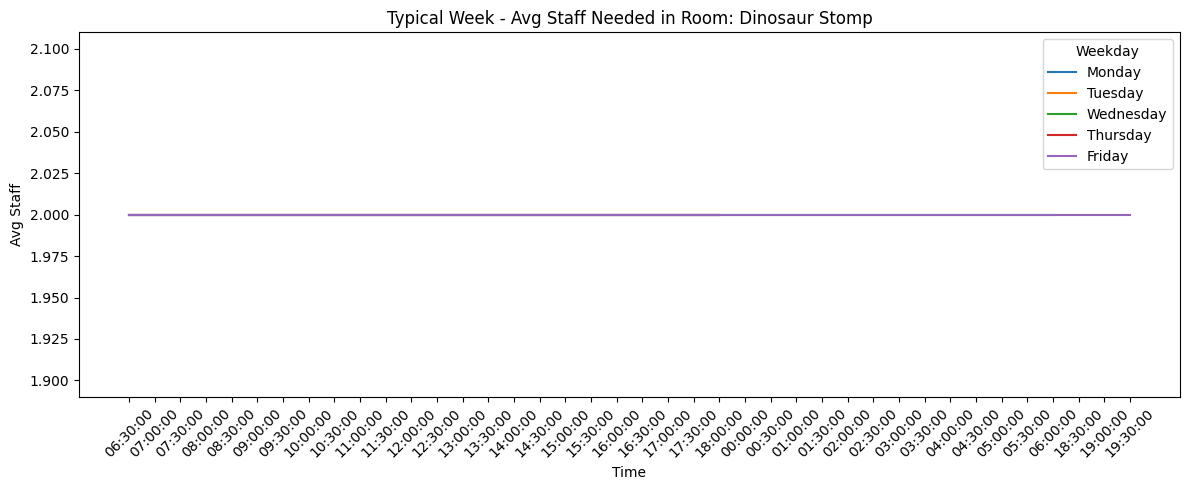

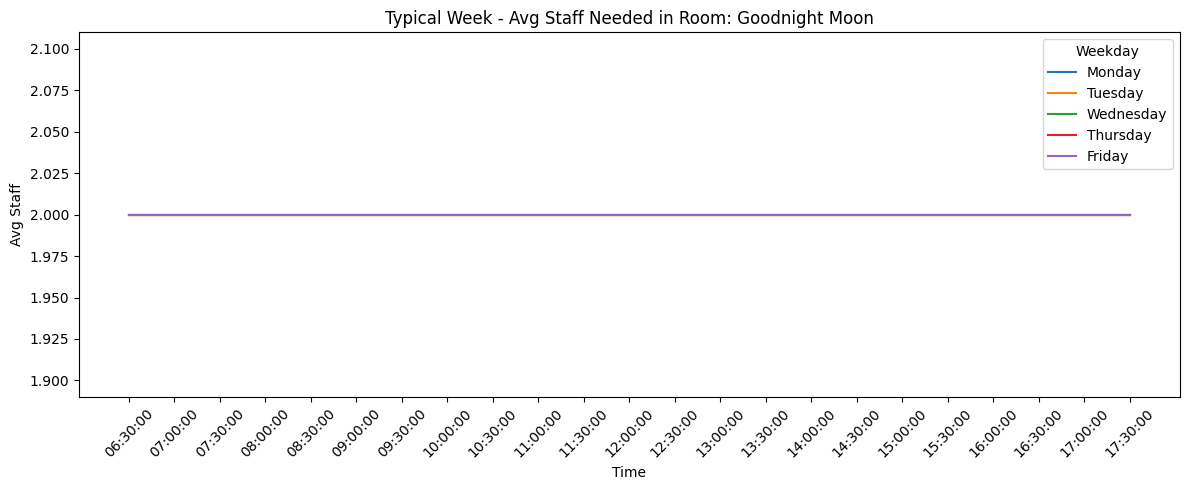

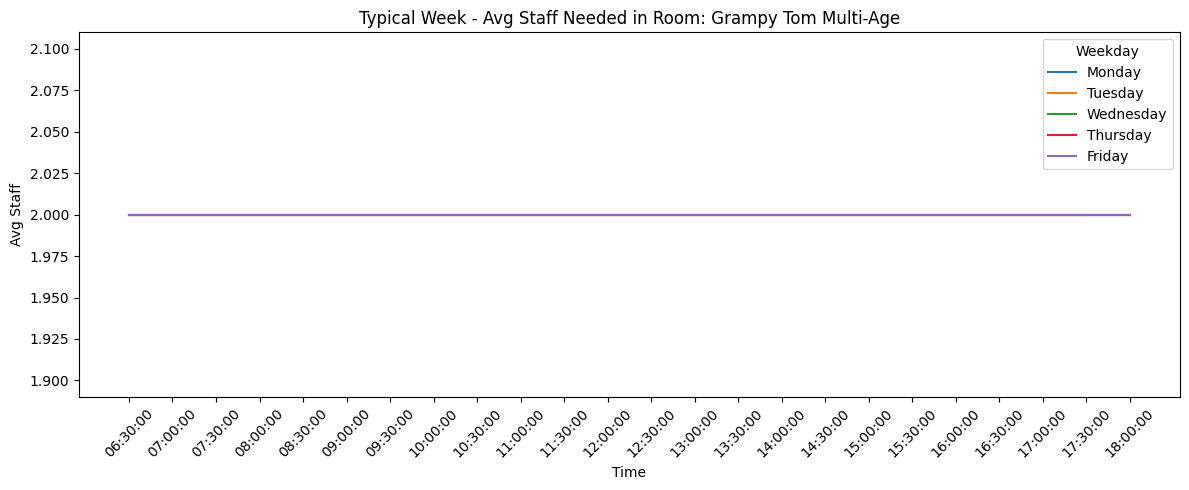

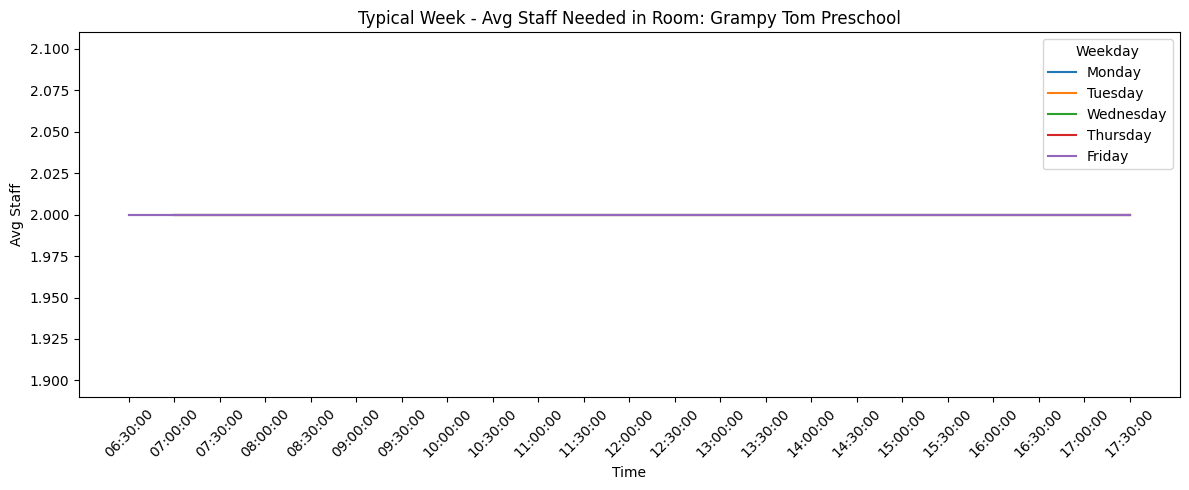

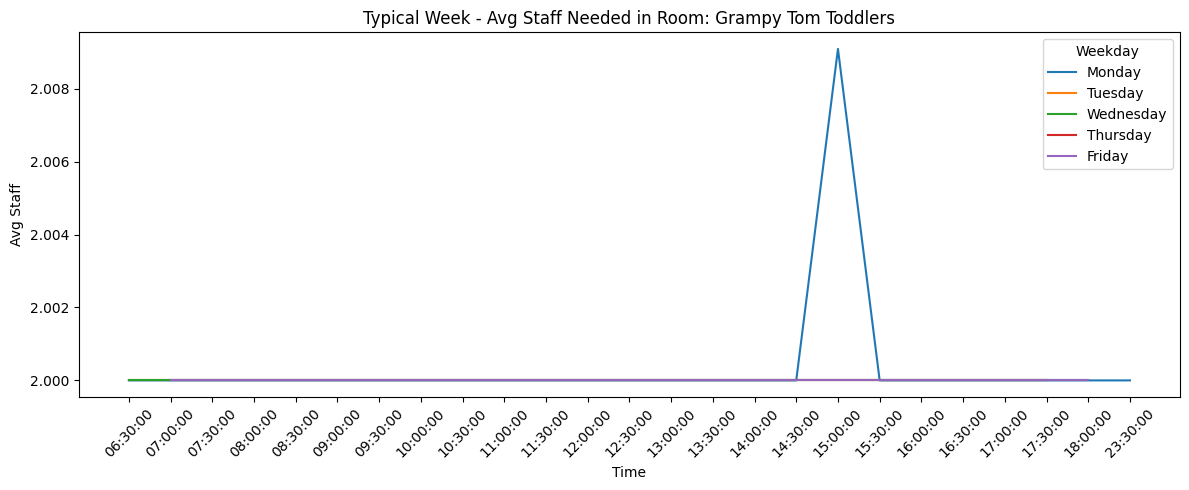

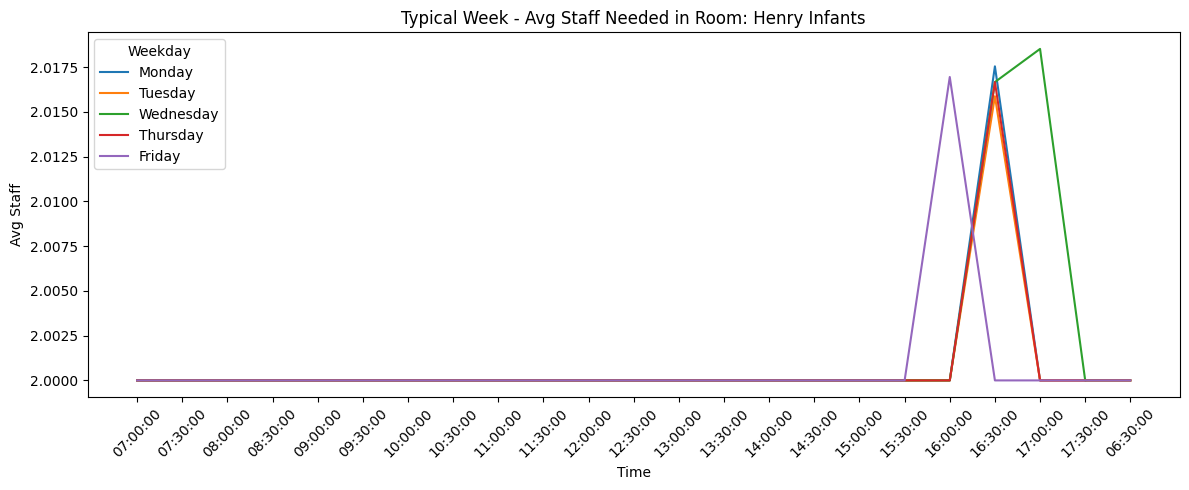

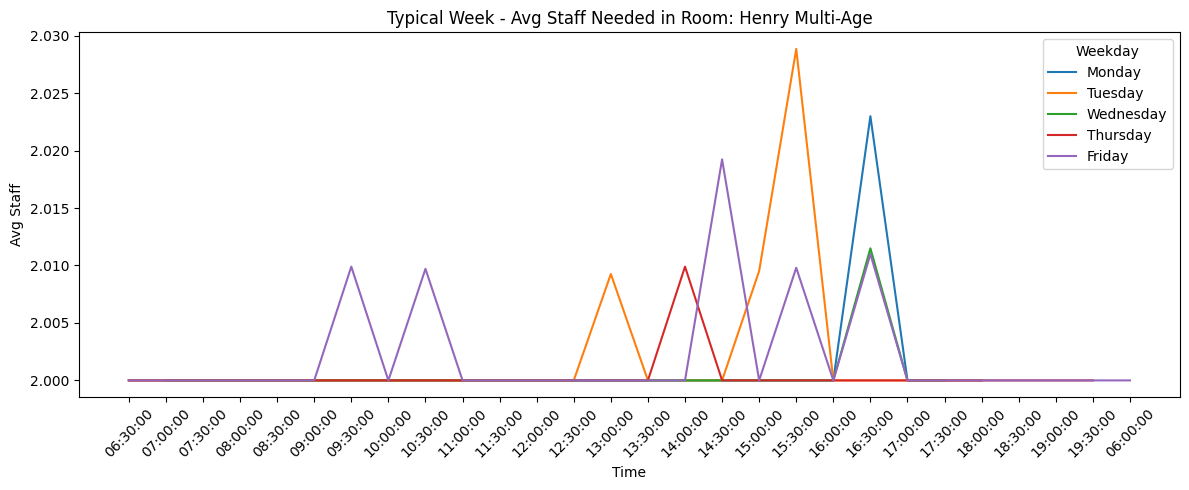

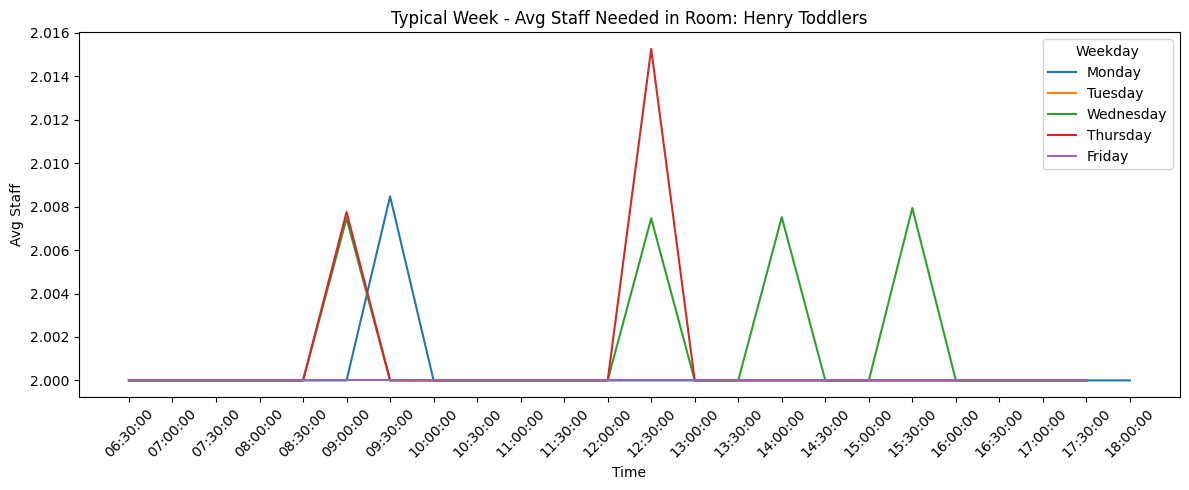

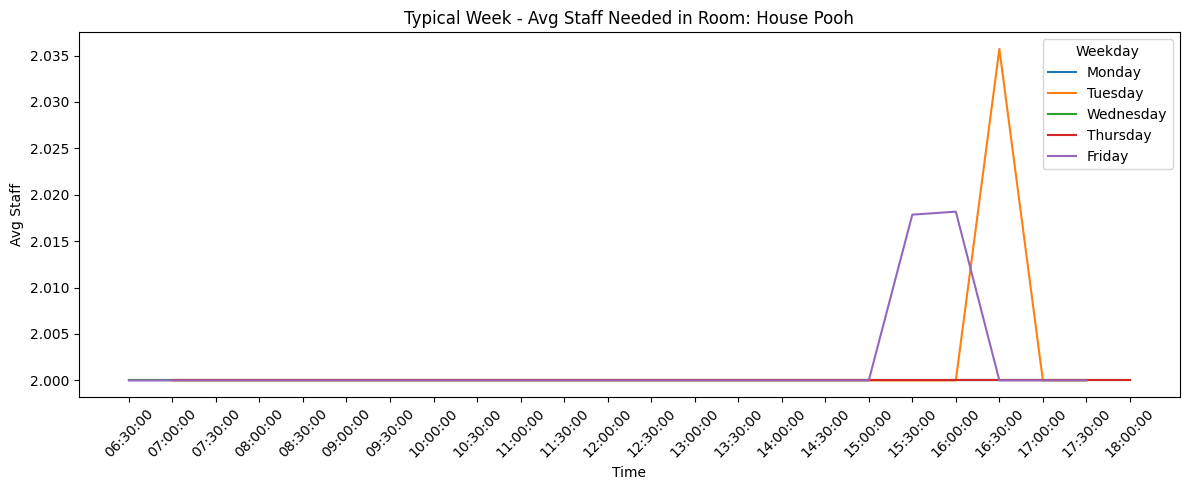

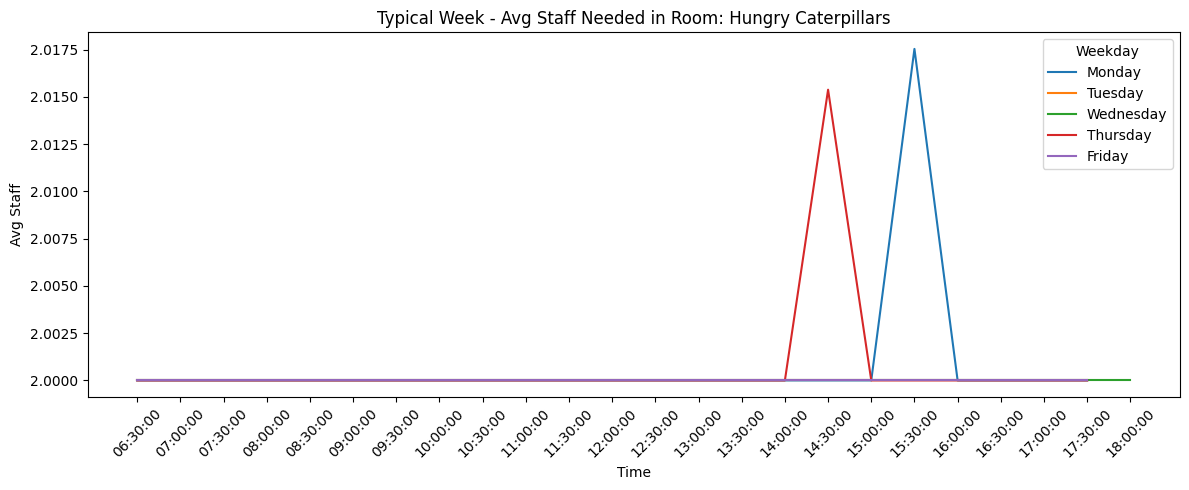

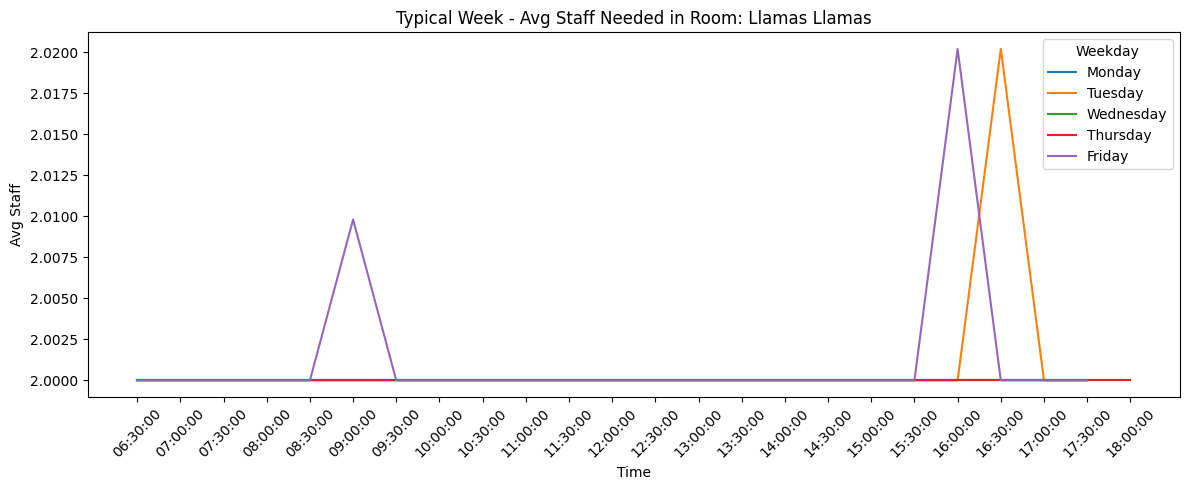

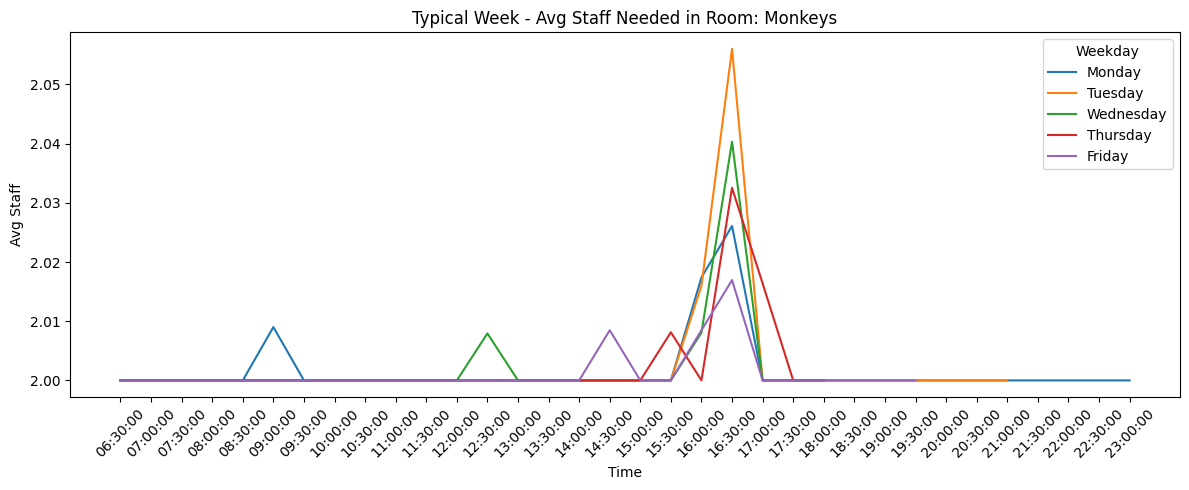

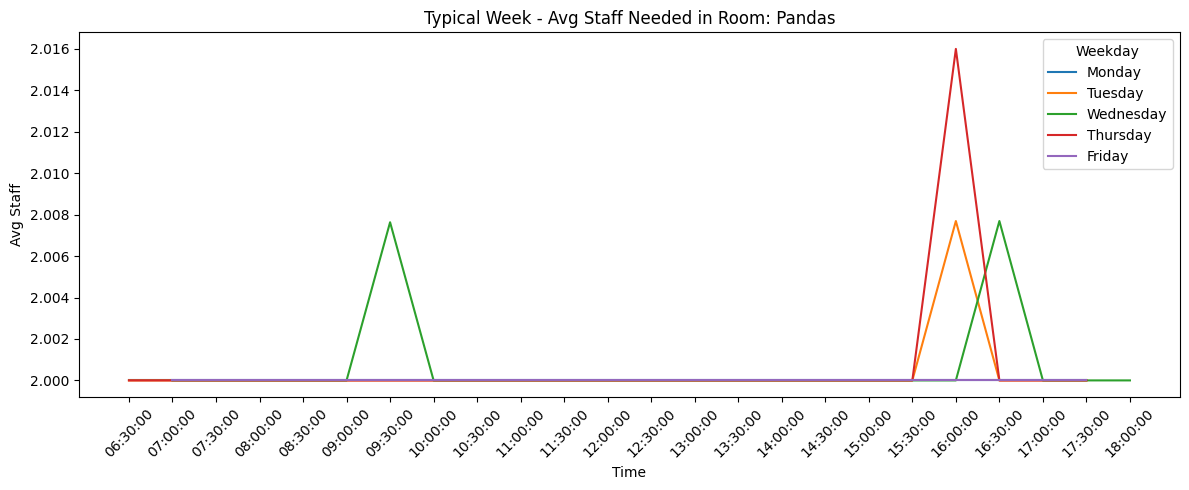

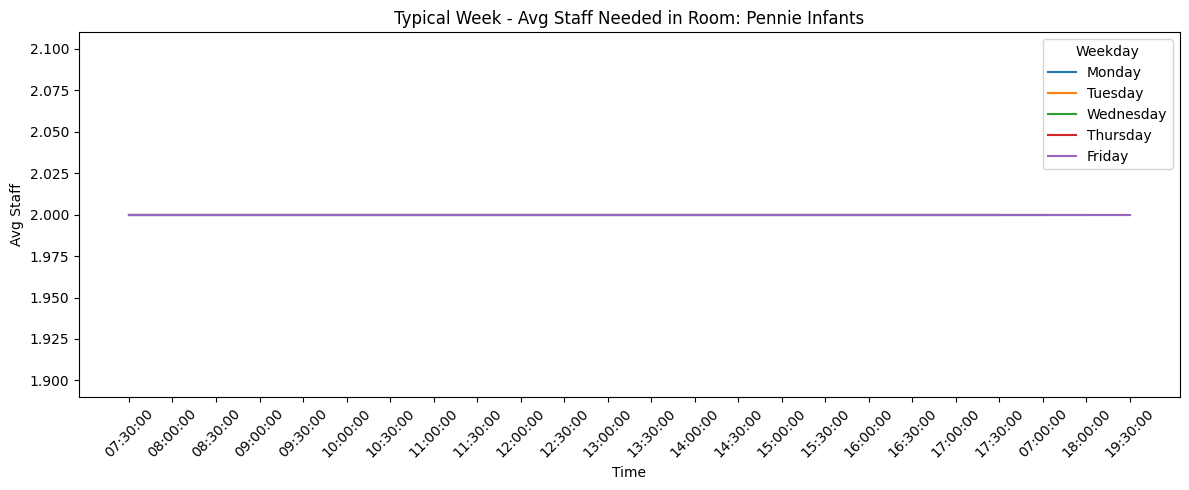

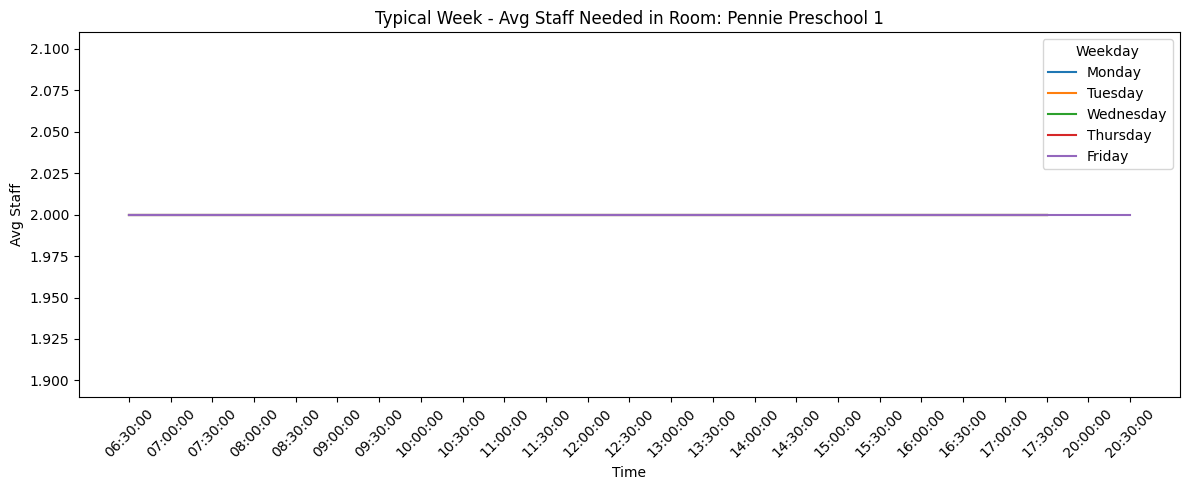

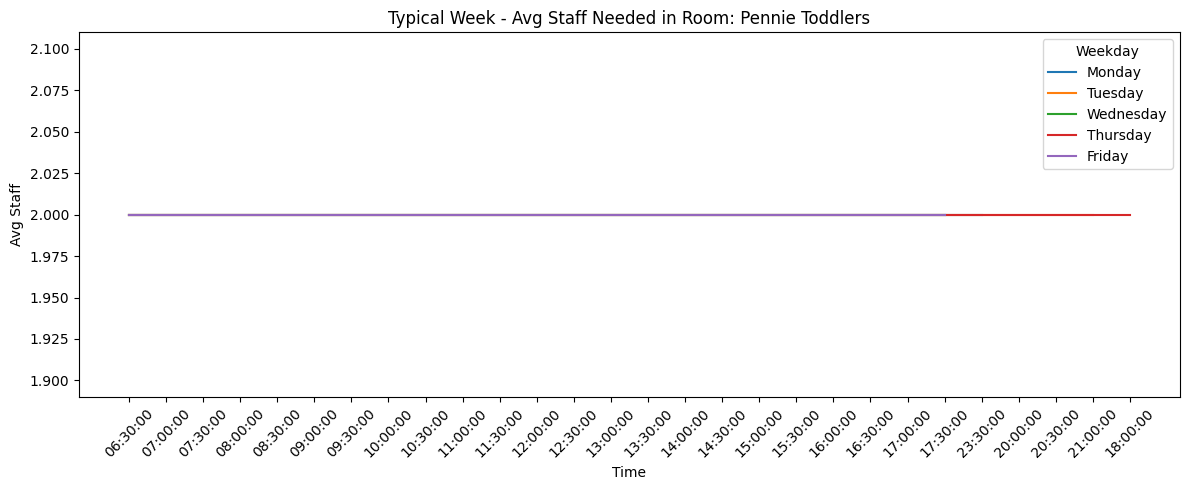

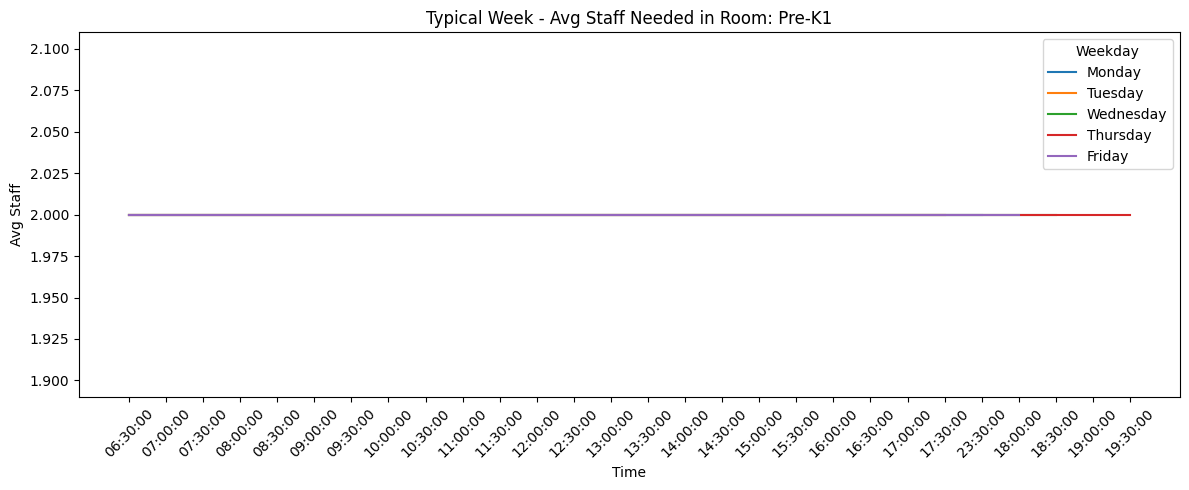

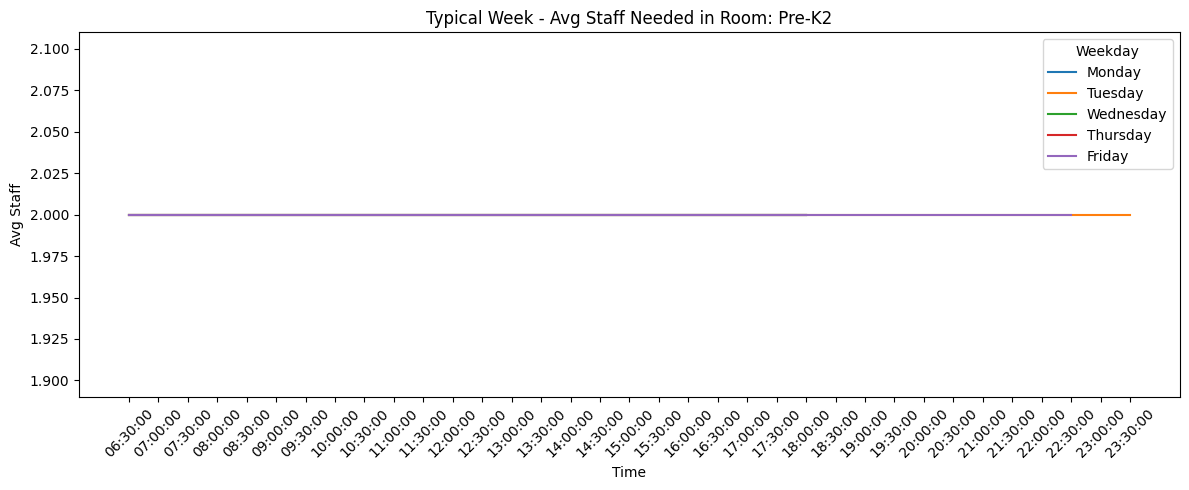

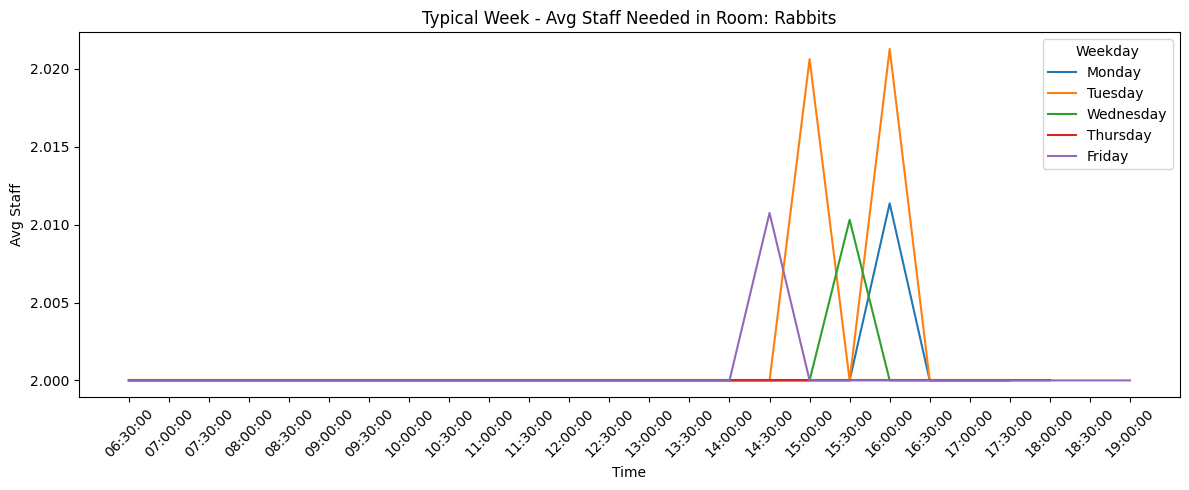

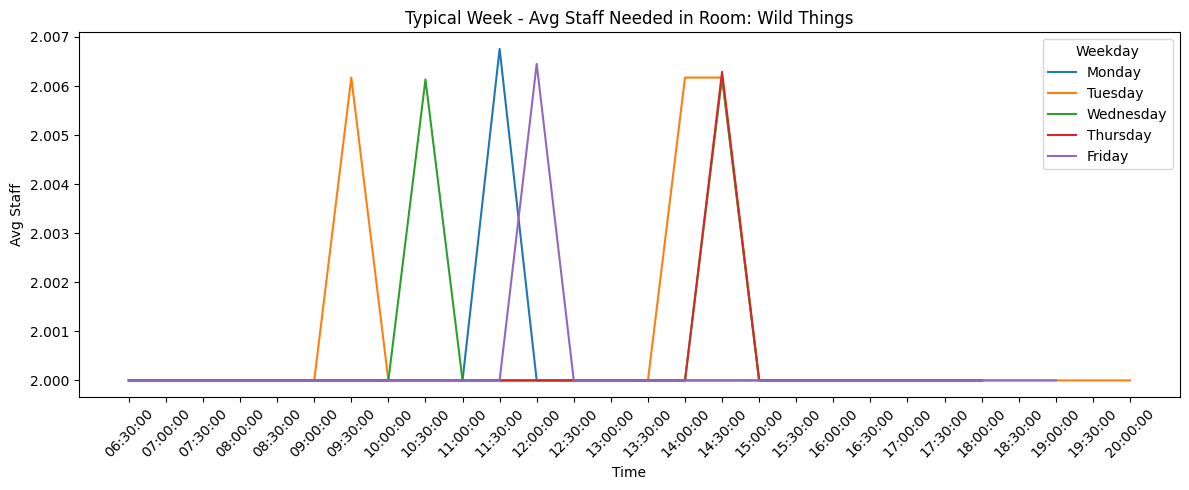

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("/content/Combined_ECEC_Spellman_DecodedRoom.csv")

# Convert date and sort weekdays
df['Date'] = pd.to_datetime(df['Date'])
df['Weekday'] = df['Date'].dt.day_name()
df['Weekday_Num'] = df['Date'].dt.weekday
df['Hour'] = df['Time'].str.slice(0, 2).astype(int)
df['Timeblock'] = df['Weekday_Num'].astype(str) + "_" + df['Time']

# Create a weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# --- Group by Room, Weekday, and Time ---
room_summary = df.groupby(['Room', 'Weekday', 'Time'])[['Num_Children', 'Staff_Needed']].mean().reset_index()

# --- Plot average children per room ---
top_rooms = room_summary['Room'].value_counts().head().index

for room in top_rooms:
    room_data = room_summary[room_summary['Room'] == room].copy()
    room_data['Weekday'] = pd.Categorical(room_data['Weekday'], categories=weekday_order, ordered=True)
    room_data = room_data.sort_values(by=['Weekday', 'Time'])

    plt.figure(figsize=(12, 5))
    sns.lineplot(data=room_data, x='Time', y='Num_Children', hue='Weekday')
    plt.title(f"Typical Week - Avg Number of Children in Room: {room}")
    plt.xticks(rotation=45)
    plt.ylabel("Avg Children")
    plt.tight_layout()
    plt.show()

# --- Plot average staff needed per room ---
for room in rooms:
    room_data = room_summary[room_summary['Room'] == room].copy()
    room_data['Weekday'] = pd.Categorical(room_data['Weekday'], categories=weekday_order, ordered=True)
    room_data = room_data.sort_values(by=['Weekday', 'Time'])

    plt.figure(figsize=(12, 5))
    sns.lineplot(data=room_data, x='Time', y='Staff_Needed', hue='Weekday')
    plt.title(f"Typical Week - Avg Staff Needed in Room: {room}")
    plt.xticks(rotation=45)
    plt.ylabel("Avg Staff")
    plt.tight_layout()
    plt.show()

10. XGBoost Forecasting & Next-Week Prediction
We begin by loading the fully decoded dataset, reconstruct Datetime, and re-extract hour, minute, weekday, and timestamp features. After filtering to weekdays only, we loop over each Room, split its historical half-hourly data into train/test (holding out the last 336 blocks), and run a GridSearchCV on XGBRegressor to tune n_estimators, max_depth, learning_rate, subsample, and colsample_bytree. We fit the best model on all data, then generate a future index of the next 336 half-hour blocks (Mon–Fri), compute the same features, and predict Staff_Needed_Predicted. Forecasts for all rooms are concatenated and saved to "XGBoost_NextWeek_Forecast_By_Room.csv".

Fitting 3 folds for each of 32 candidates, totalling 96 fits
✅ Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
             Datetime  hour  minute  weekday   timestamp  \
0 2025-02-28 18:30:00    18      30        4  1740767400   
1 2025-02-28 19:00:00    19       0        4  1740769200   
2 2025-02-28 19:30:00    19      30        4  1740771000   
3 2025-02-28 20:00:00    20       0        4  1740772800   
4 2025-02-28 20:30:00    20      30        4  1740774600   

   Staff_Needed_Predicted  
0                4.469193  
1                6.952414  
2                4.330793  
3                6.864715  
4                4.243094  


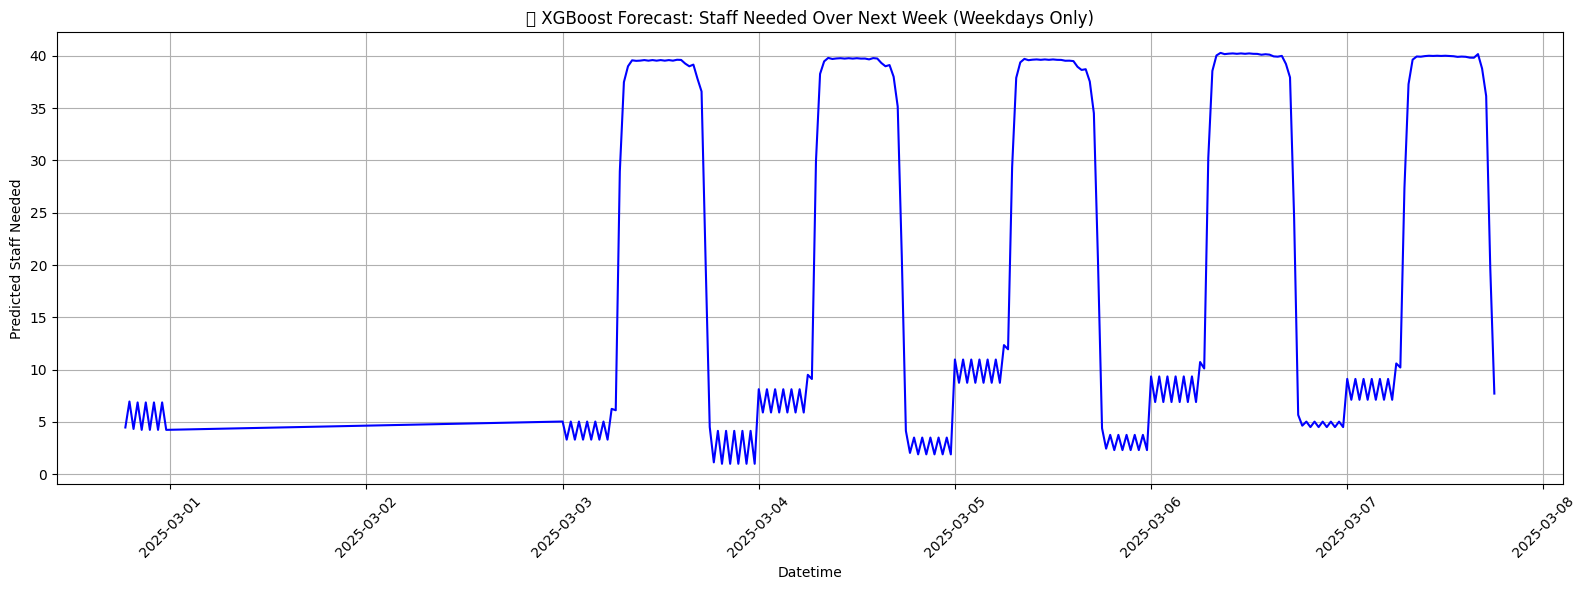

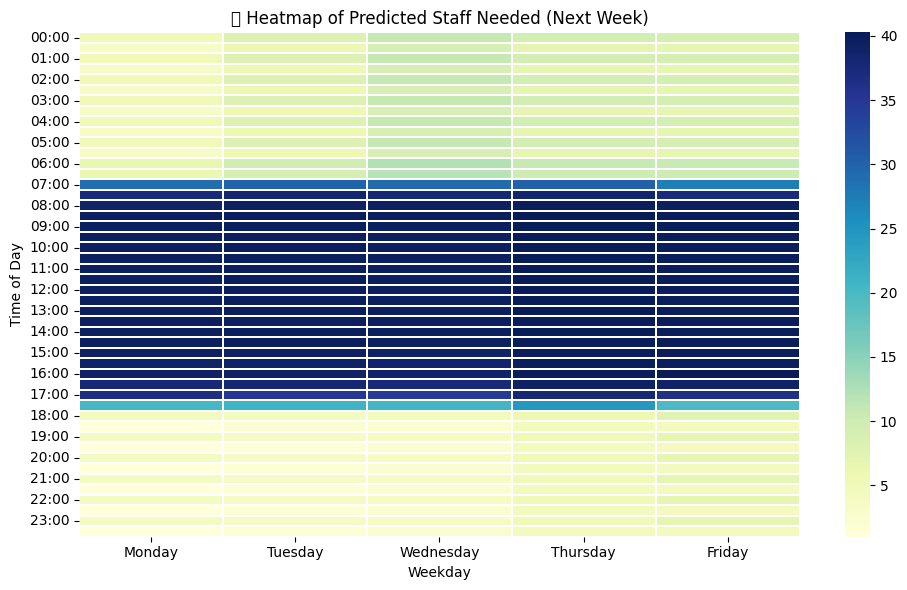

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# Load data
df = pd.read_csv("/content/Combined_ECEC_Spellman_DecodedRoom.csv")
df['Date'] = pd.to_datetime(df['Date'])
df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'])

# Aggregate staff needed
df_grouped = df.groupby('Datetime')['Staff_Needed'].sum().reset_index().sort_values('Datetime')

# Feature engineering
df_grouped['hour'] = df_grouped['Datetime'].dt.hour
df_grouped['minute'] = df_grouped['Datetime'].dt.minute
df_grouped['weekday'] = df_grouped['Datetime'].dt.weekday
df_grouped['timestamp'] = df_grouped['Datetime'].astype(np.int64) // 10**9

# ❌ Remove weekends (Saturday=5, Sunday=6)
df_grouped = df_grouped[df_grouped['weekday'] < 5]

# Train/test split (last 7 days of weekdays only)
X = df_grouped[['hour', 'minute', 'weekday', 'timestamp']]
y = df_grouped['Staff_Needed']

X_train = X.iloc[:-336]
y_train = y.iloc[:-336]
X_test = X.iloc[-336:]
y_test = y.iloc[-336:]

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Grid search
model = XGBRegressor(random_state=42)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=3, verbose=1)
grid.fit(X_train, y_train)

# Best model
best_model = grid.best_estimator_
print("✅ Best Parameters:", grid.best_params_)

# Refit model on all weekday data
best_model.fit(X, y)

# Forecast next 7 days (336 intervals)
last_time = df_grouped['Datetime'].max()
future_times = pd.date_range(start=last_time + pd.Timedelta(minutes=30), periods=336, freq='30min')

future_df = pd.DataFrame()
future_df['Datetime'] = future_times
future_df['hour'] = future_df['Datetime'].dt.hour
future_df['minute'] = future_df['Datetime'].dt.minute
future_df['weekday'] = future_df['Datetime'].dt.weekday
future_df['timestamp'] = future_df['Datetime'].astype(np.int64) // 10**9

# ❌ Remove weekends from forecast
future_df = future_df[future_df['weekday'] < 5]

# Predict
future_df['Staff_Needed_Predicted'] = best_model.predict(future_df[['hour', 'minute', 'weekday', 'timestamp']])

# Save result
future_df[['Datetime', 'Staff_Needed_Predicted']].to_csv("XGBoost_Tuned_Weekday_Only_Forecast.csv", index=False)
print(future_df.head())
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# === LOAD & PREPARE DATA ===
df = pd.read_csv("Combined_ECEC_Spellman_with_Features_Renamed.csv")
df['Date'] = pd.to_datetime(df['Date'])
df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'])

df_grouped = df.groupby('Datetime')['Staff_Needed'].sum().reset_index().sort_values('Datetime')
df_grouped['hour'] = df_grouped['Datetime'].dt.hour
df_grouped['minute'] = df_grouped['Datetime'].dt.minute
df_grouped['weekday'] = df_grouped['Datetime'].dt.weekday
df_grouped['timestamp'] = df_grouped['Datetime'].astype(np.int64) // 10**9

# Remove weekends
df_grouped = df_grouped[df_grouped['weekday'] < 5]

# === TRAIN MODEL ===
X = df_grouped[['hour', 'minute', 'weekday', 'timestamp']]
y = df_grouped['Staff_Needed']

X_train, y_train = X.iloc[:-336], y.iloc[:-336]

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

model = XGBRegressor(random_state=42)
grid = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', cv=3, verbose=0)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_
best_model.fit(X, y)

# === FORECAST NEXT WEEK (WEEKDAYS ONLY) ===
last_time = df_grouped['Datetime'].max()
future_times = pd.date_range(start=last_time + pd.Timedelta(minutes=30), periods=336, freq='30min')

future_df = pd.DataFrame()
future_df['Datetime'] = future_times
future_df['hour'] = future_df['Datetime'].dt.hour
future_df['minute'] = future_df['Datetime'].dt.minute
future_df['weekday'] = future_df['Datetime'].dt.weekday
future_df['timestamp'] = future_df['Datetime'].astype(np.int64) // 10**9

# Keep only weekdays
future_df = future_df[future_df['weekday'] < 5]
future_df['Staff_Needed_Predicted'] = best_model.predict(future_df[['hour', 'minute', 'weekday', 'timestamp']])
future_df.to_csv("XGBoost_Tuned_Weekday_Only_Forecast.csv", index=False)

# === VISUALIZE ===
# Line chart
plt.figure(figsize=(16, 6))
plt.plot(future_df['Datetime'], future_df['Staff_Needed_Predicted'], color='blue')
plt.title("📈 XGBoost Forecast: Staff Needed Over Next Week (Weekdays Only)")
plt.xlabel("Datetime")
plt.ylabel("Predicted Staff Needed")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Heatmap
future_df['Weekday'] = future_df['Datetime'].dt.day_name()
future_df['Hour'] = future_df['Datetime'].dt.strftime('%H:%M')
pivot = future_df.pivot_table(index='Hour', columns='Weekday', values='Staff_Needed_Predicted')
pivot = pivot[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']]  # Order

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap='YlGnBu', linewidths=0.3)
plt.title("🟦 Heatmap of Predicted Staff Needed (Next Week)")
plt.xlabel("Weekday")
plt.ylabel("Time of Day")
plt.tight_layout()
plt.show()


In this section, we import Pandas and NumPy for data handling, Matplotlib and Seaborn for plotting, `GridSearchCV` for hyperparameter tuning, and `XGBRegressor` as our forecasting model. We load the cleaned dataset, parse `Date` and `Time` into a single `Datetime` column, then extract `hour`, `minute`, `weekday` (0–6), and a numeric `timestamp` (seconds since epoch). We filter to weekdays only to focus on regular operating days.

We then loop over each unique `Room`, splitting its historical half-hourly data into a training set (all but the last 336 records) and holding out the rest for forecasting. Within each loop, we define a parameter grid for XGBoost (trees, depth, learning rate, subsample ratios), run a 3-fold time-aware grid search optimizing RMSE, and fit the best model on the room’s full history. To predict next week’s staffing, we generate a future index of 336 half-hour intervals (next Mon–Fri), compute the same feature columns, and call `.predict()` to produce `Staff_Needed_Predicted`. We collect these room-level forecasts into one DataFrame and export it to CSV.

Finally, we visualize the results in two ways:

1. **Line Plot:** Overlay each room’s predicted staffing curve over the full next-week timeline, revealing how demand fluctuates by room and day.
2. **Heatmaps:** For each room, pivot the forecast into a matrix of `Time` (rows) vs. `Weekday` (columns) and render a color-coded heatmap—intensity reflects predicted staff counts, making it easy to spot peak and off-peak periods at a glance.


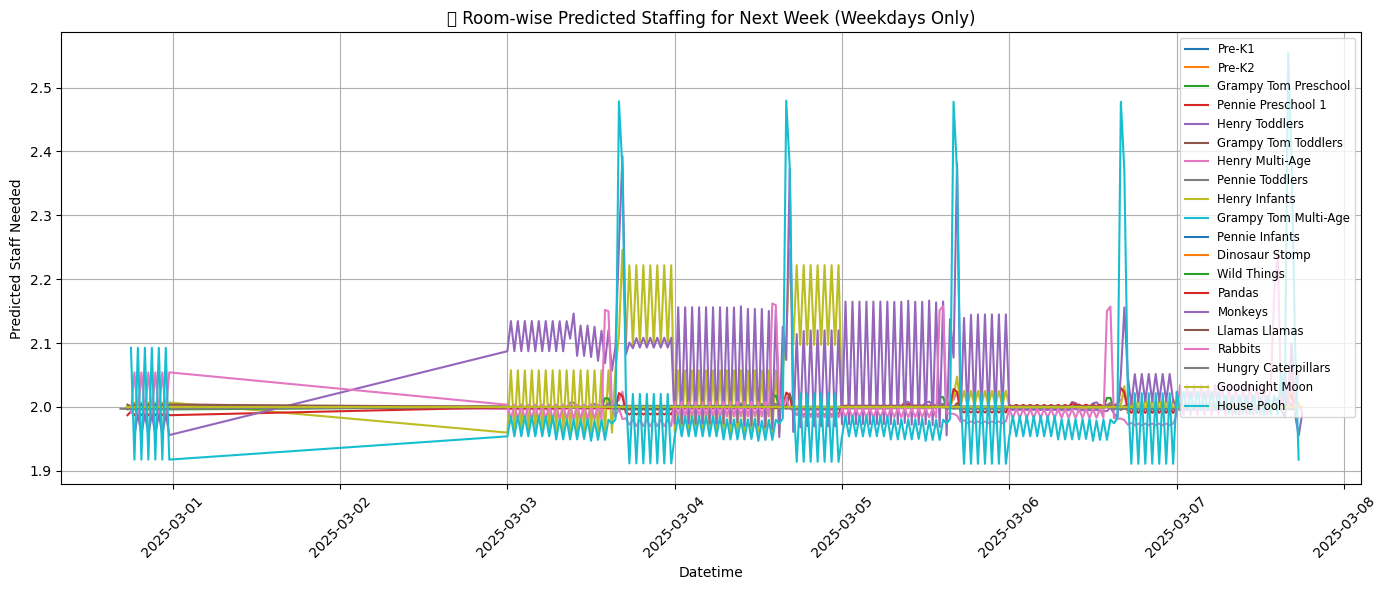

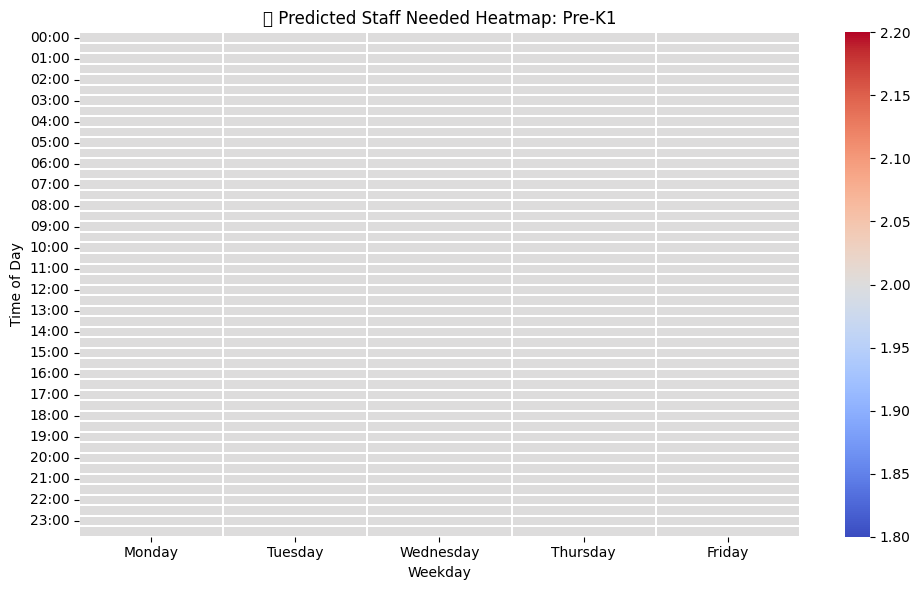

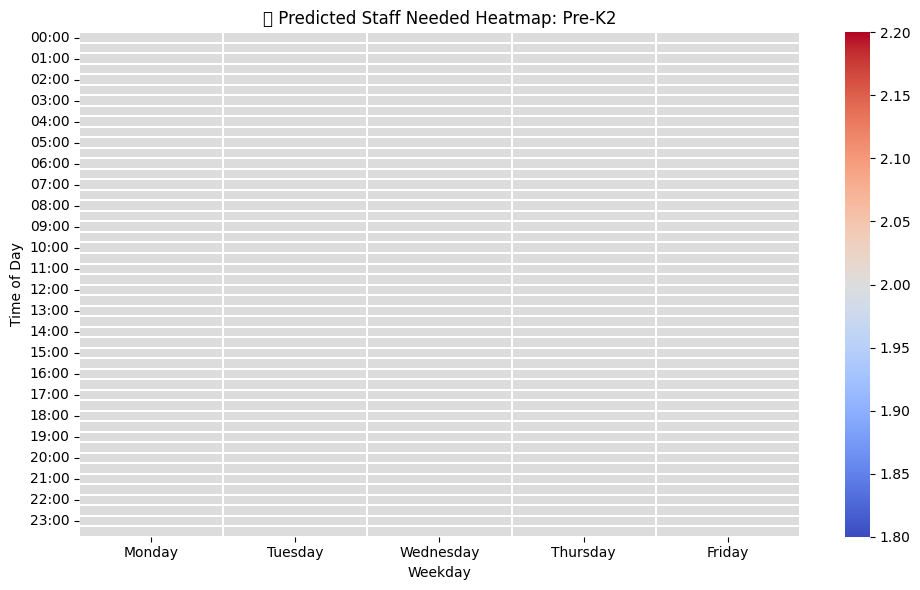

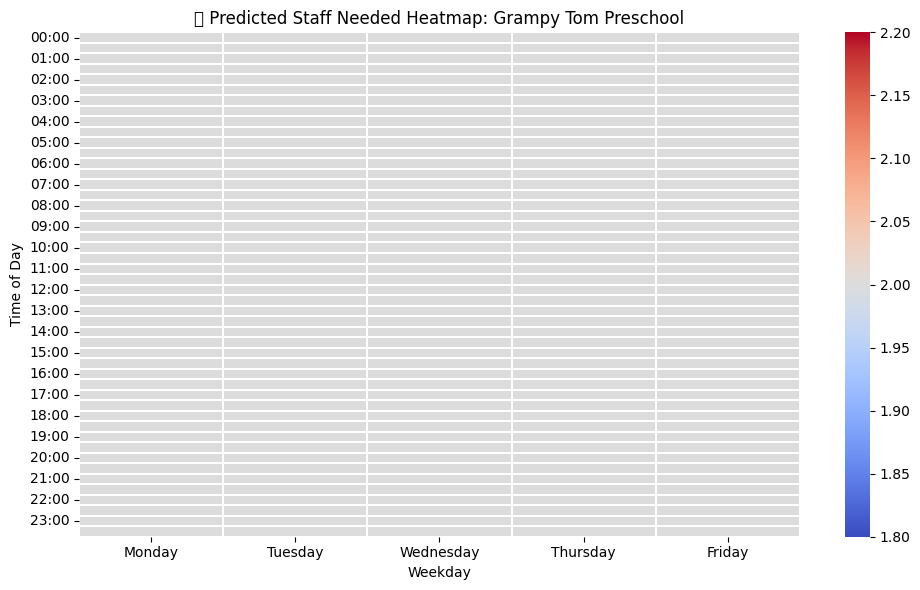

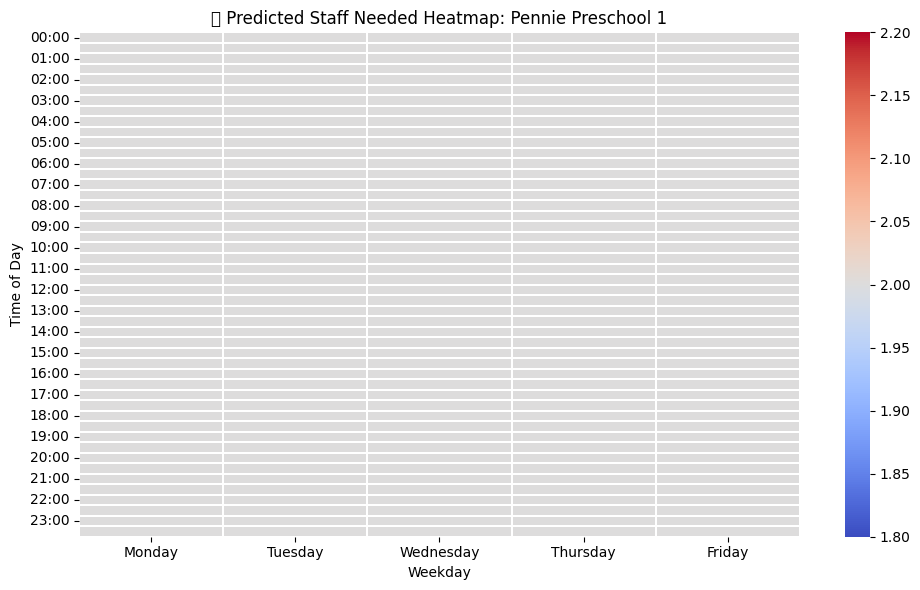

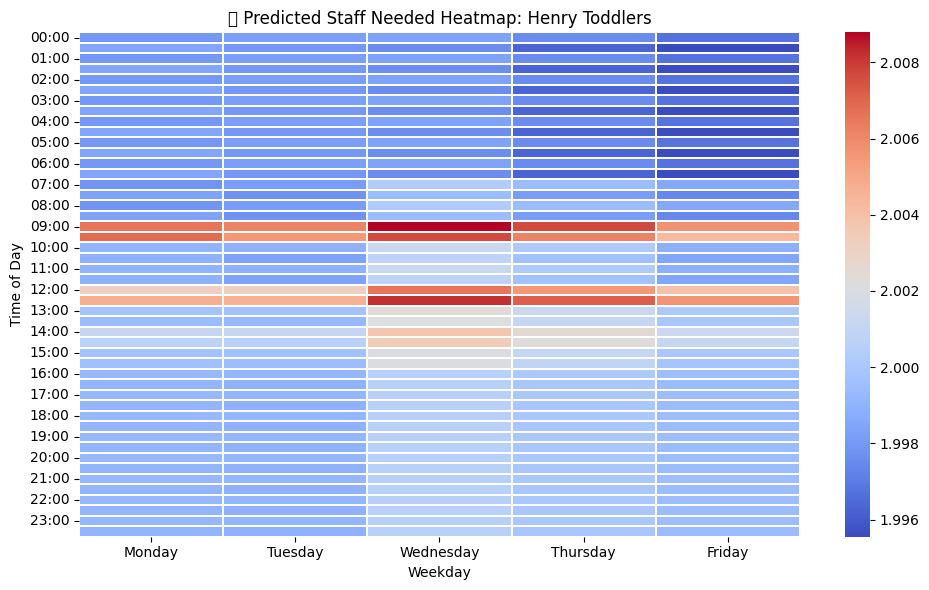

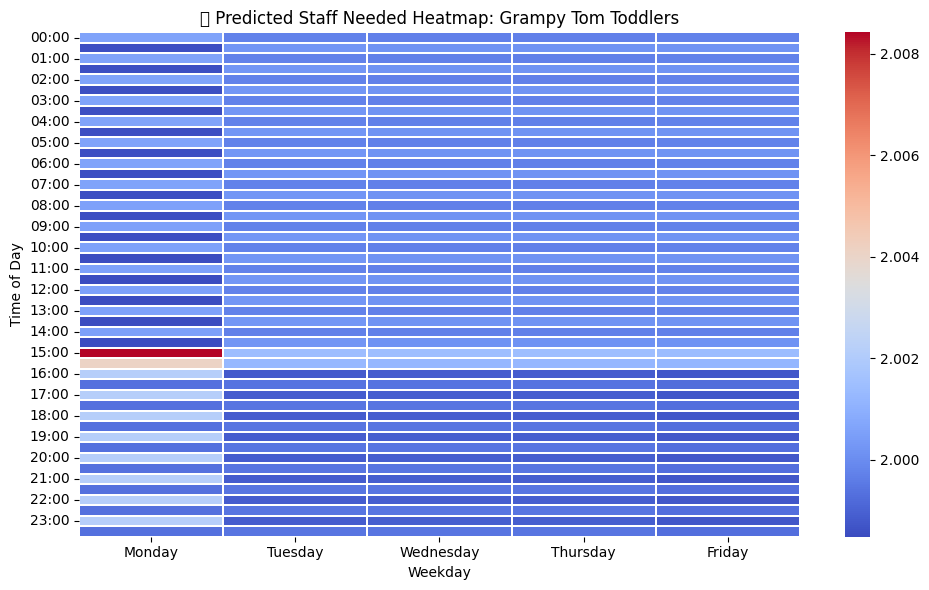

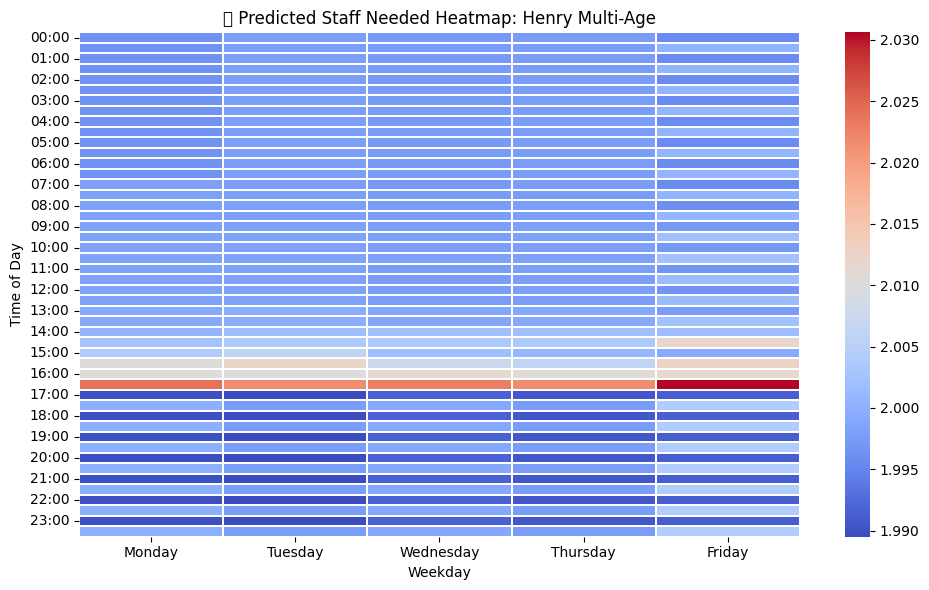

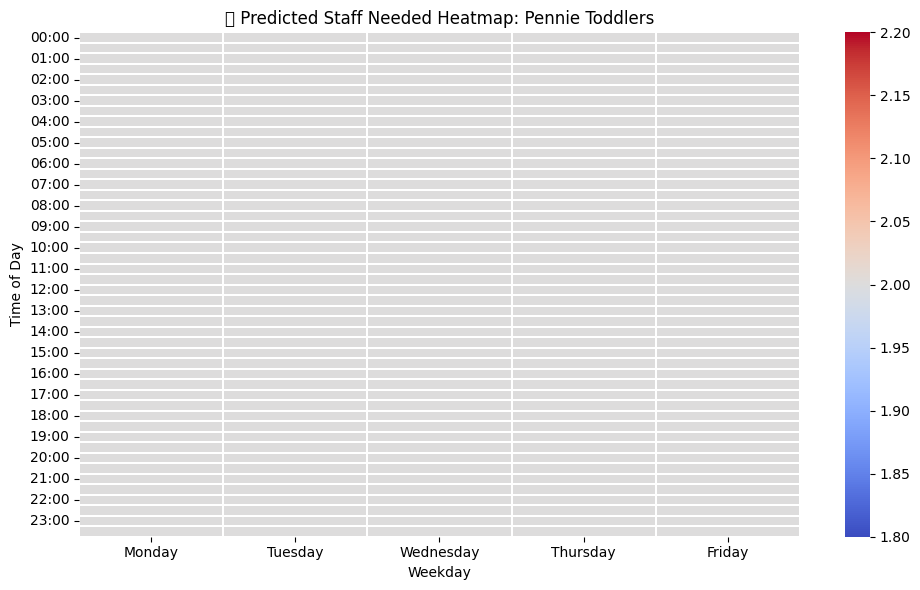

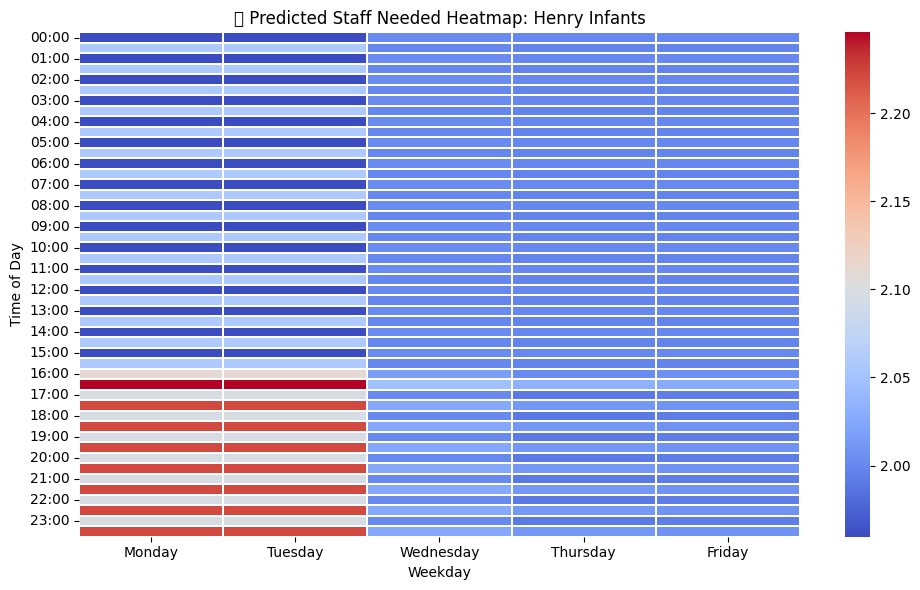

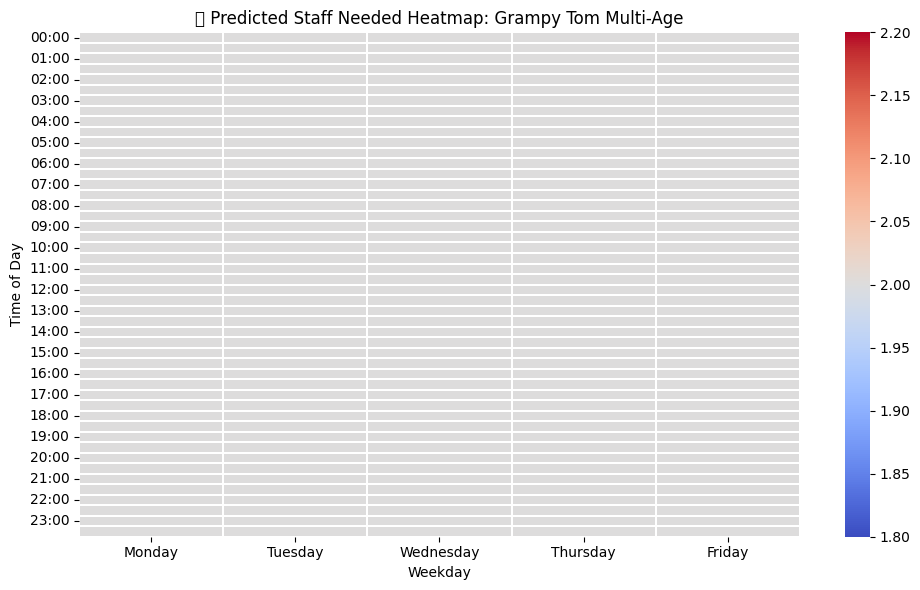

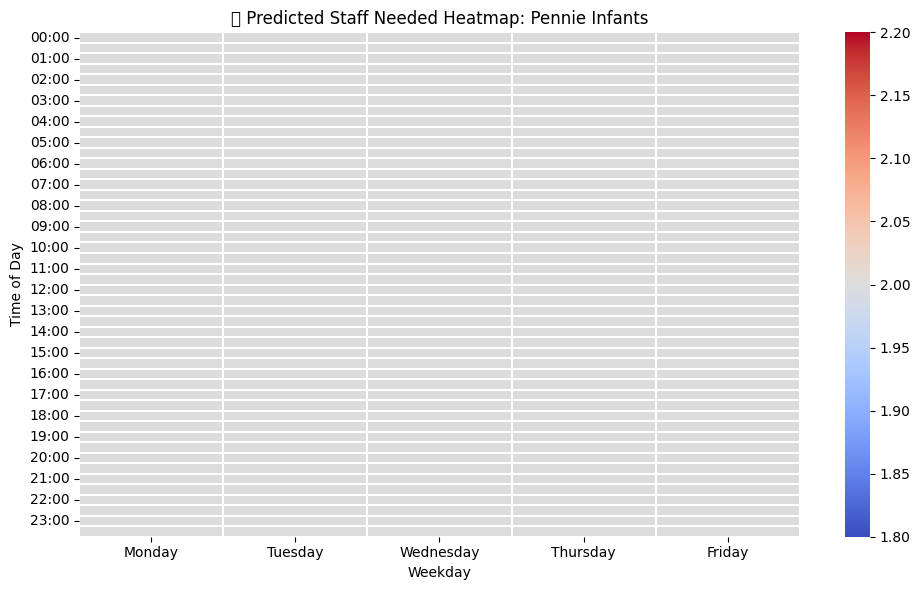

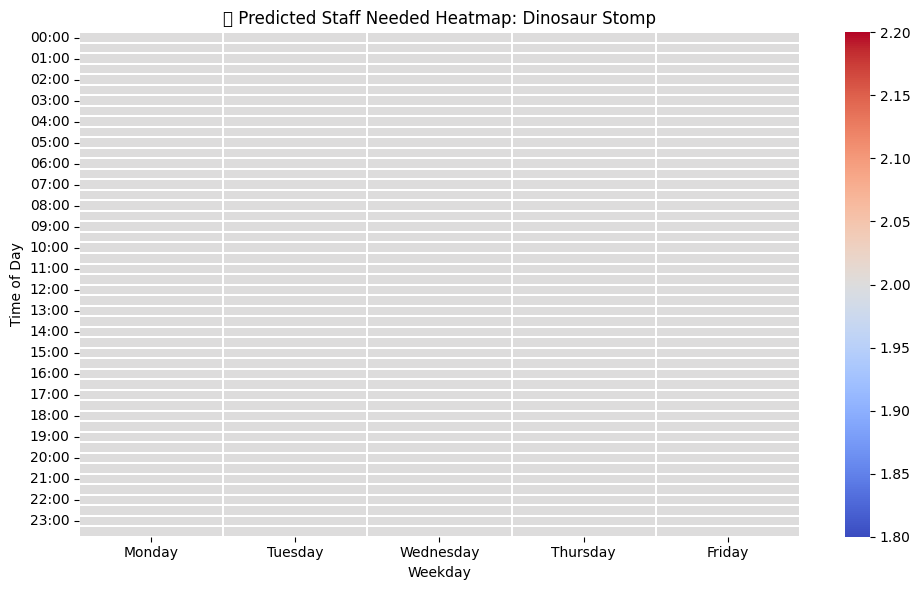

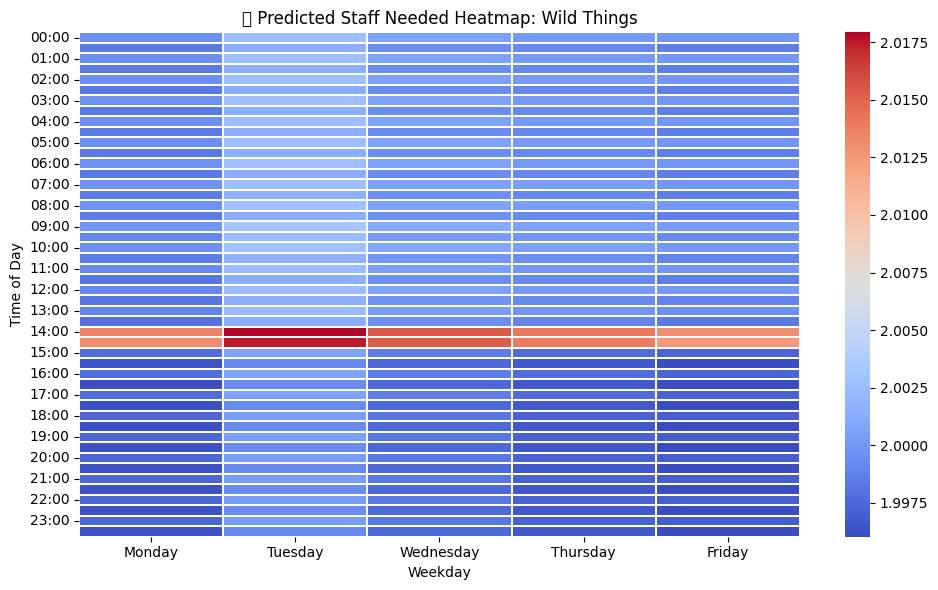

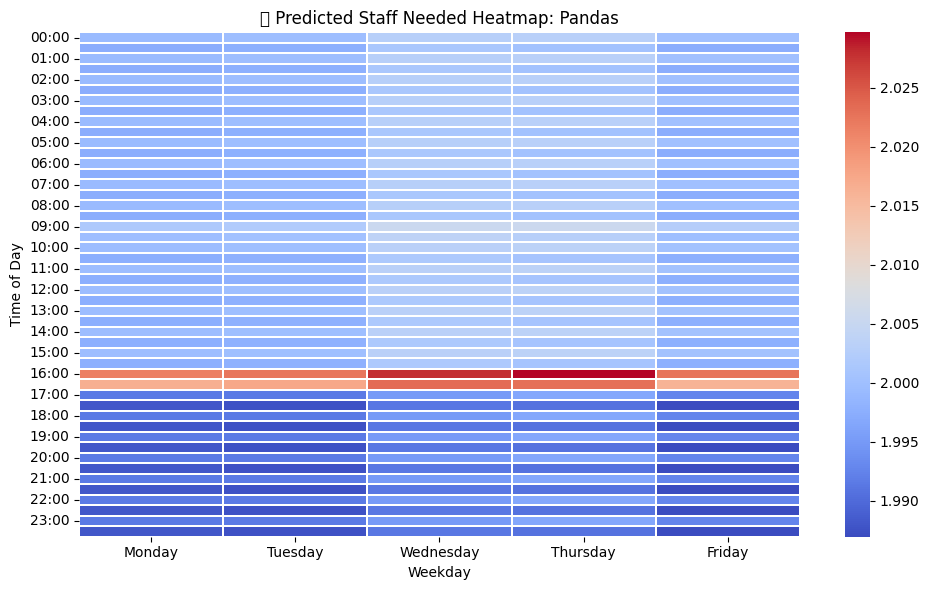

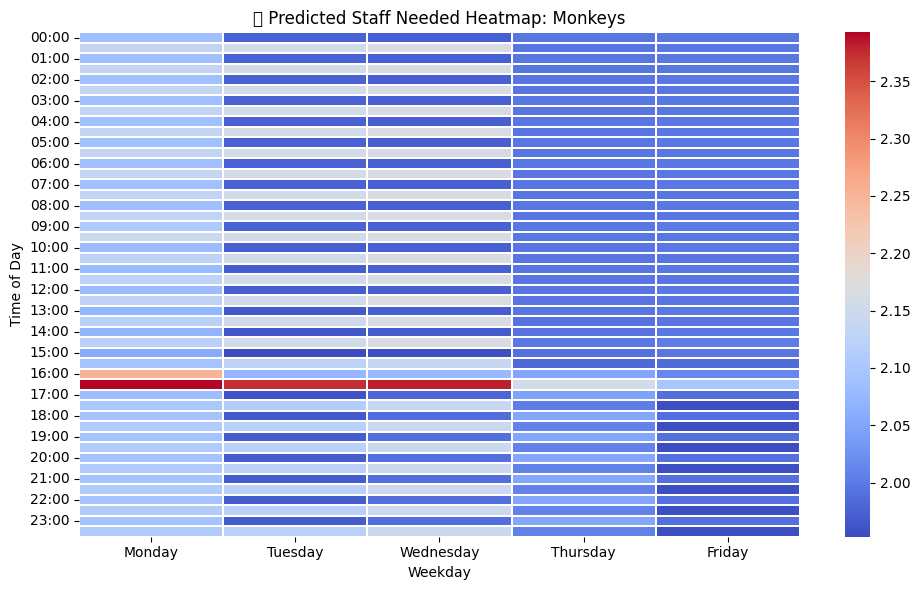

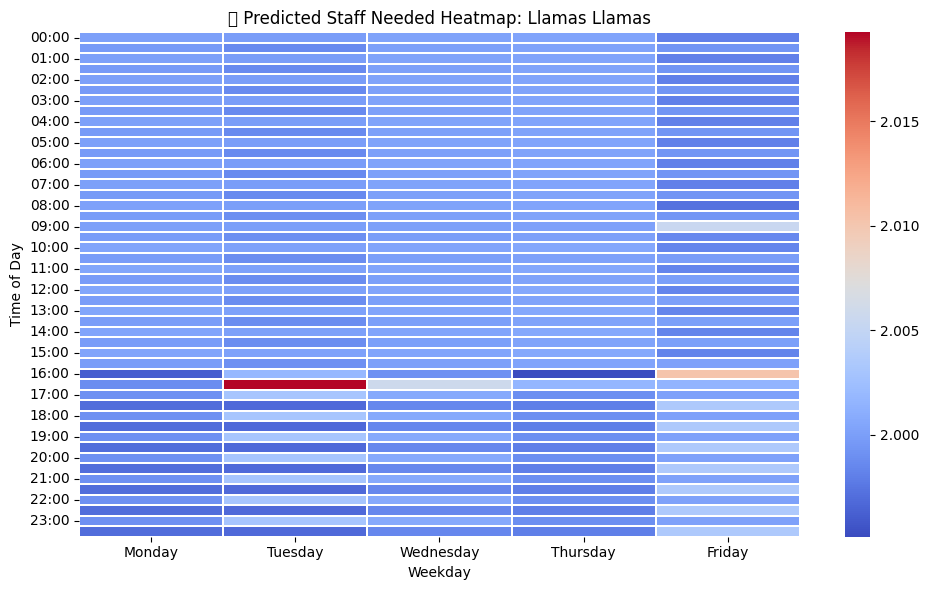

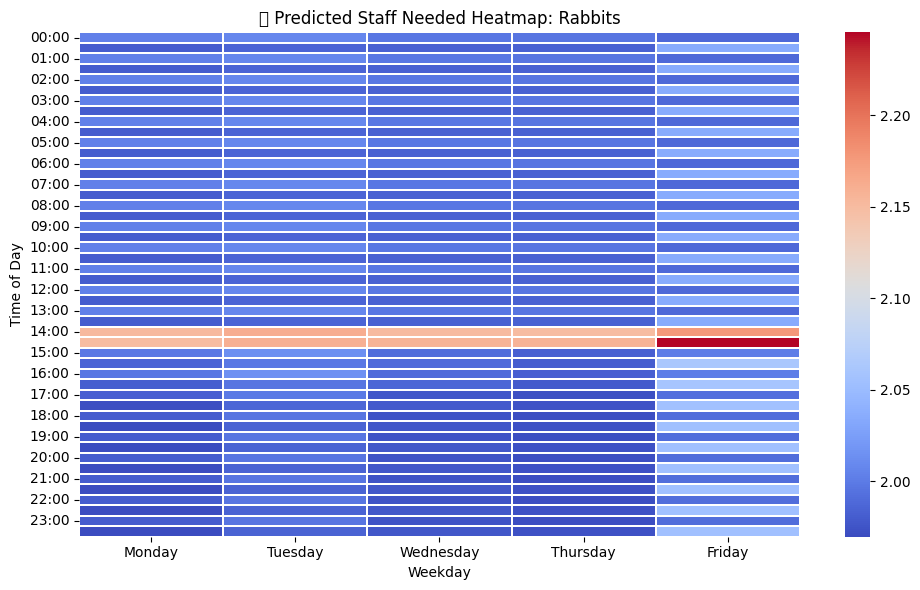

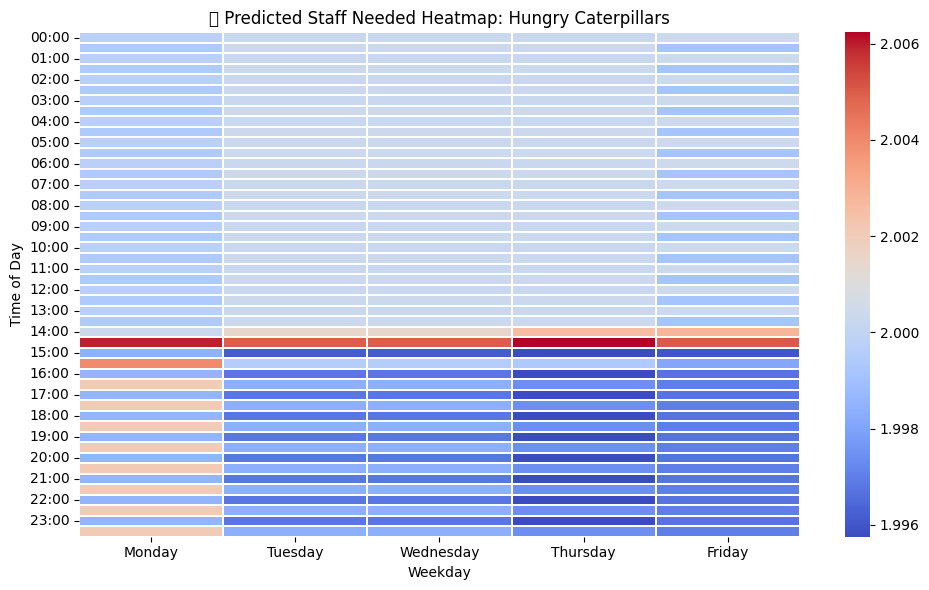

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Load data
df = pd.read_csv("/content/Combined_ECEC_Spellman_DecodedRoom.csv")
df['Date'] = pd.to_datetime(df['Date'])
df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'])
df['hour'] = df['Datetime'].dt.hour
df['minute'] = df['Datetime'].dt.minute
df['weekday'] = df['Datetime'].dt.weekday
df['timestamp'] = df['Datetime'].astype(np.int64) // 10**9

# Only weekdays
df = df[df['weekday'] < 5]

# Prepare result container
room_forecasts = []
unique_rooms = df['Room'].unique()

for room in unique_rooms:
    df_room = df[df['Room'] == room].copy()


    X = df_room[['hour', 'minute', 'weekday', 'timestamp']]
    y = df_room['Staff_Needed']

    # Split train/test
    X_train, y_train = X.iloc[:-336], y.iloc[:-336]

    # Grid Search
    param_grid = {
        'n_estimators': [100],
        'max_depth': [3, 5],
        'learning_rate': [0.1],
        'subsample': [0.8],
        'colsample_bytree': [0.8]
    }
    model = XGBRegressor(random_state=42)
    grid = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', cv=3, verbose=0)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    best_model.fit(X, y)

    # Future forecasting (336 blocks for next Mon–Fri)
    last_time = df_room['Datetime'].max()
    future_times = pd.date_range(start=last_time + pd.Timedelta(minutes=30), periods=336, freq='30min')
    future_df = pd.DataFrame()
    future_df['Datetime'] = future_times
    future_df['hour'] = future_df['Datetime'].dt.hour
    future_df['minute'] = future_df['Datetime'].dt.minute
    future_df['weekday'] = future_df['Datetime'].dt.weekday
    future_df['timestamp'] = future_df['Datetime'].astype(np.int64) // 10**9
    future_df = future_df[future_df['weekday'] < 5]

    future_df['Room'] = room
    future_df['Staff_Needed_Predicted'] = best_model.predict(future_df[['hour', 'minute', 'weekday', 'timestamp']])
    room_forecasts.append(future_df)

# Combine all room forecasts
forecast_all = pd.concat(room_forecasts, ignore_index=True)
forecast_all.to_csv("XGBoost_NextWeek_Forecast_By_Room.csv", index=False)

# --- Plotting ---
# Line Plot
plt.figure(figsize=(14, 6))
for room in forecast_all['Room'].unique():
    subset = forecast_all[forecast_all['Room'] == room]
    plt.plot(subset['Datetime'], subset['Staff_Needed_Predicted'], label=room)

plt.title("📈 Room-wise Predicted Staffing for Next Week (Weekdays Only)")
plt.xlabel("Datetime")
plt.ylabel("Predicted Staff Needed")
plt.legend(loc='upper right', fontsize='small')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

# Heatmap by Room and Time
forecast_all['Time'] = forecast_all['Datetime'].dt.strftime('%H:%M')
forecast_all['Weekday'] = forecast_all['Datetime'].dt.day_name()

for room in forecast_all['Room'].unique():
    pivot = forecast_all[forecast_all['Room'] == room].pivot_table(index='Time', columns='Weekday', values='Staff_Needed_Predicted')
    pivot = pivot[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']]

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, cmap='coolwarm', linewidths=0.3)
    plt.title(f"🔵 Predicted Staff Needed Heatmap: {room}")
    plt.xlabel("Weekday")
    plt.ylabel("Time of Day")
    plt.tight_layout()
    plt.show()